In [664]:
import polars as pl
import numpy as np
from typing import List

def kalman_filter_series(
        series: pl.Series,
        R: float = 0.01,  # ËßÇÊµãÂô™Â£∞ÂçèÊñπÂ∑ÆÔºàË∂äÂ∞èË∂ä‰ø°Ôºâ
        Q: float = 1e-5   # ËøáÁ®ãÂô™Â£∞ÂçèÊñπÂ∑ÆÔºàË∂äÂ∞èË∂äÁ®≥Ôºâ
) -> pl.Series:
    z = series.to_numpy()
    n = len(z)
    x_hat = np.zeros(n)      # ‰º∞ËÆ°ÂÄº
    P = np.zeros(n)          # ‰º∞ËÆ°ËØØÂ∑ÆÂçèÊñπÂ∑Æ
    x_hat[0] = z[0]
    P[0] = 1.0

    for k in range(1, n):
        # È¢ÑÊµãÊõ¥Êñ∞
        x_hat_minus = x_hat[k - 1]
        P_minus = P[k - 1] + Q

        # ËßÇÊµãÊõ¥Êñ∞
        K = P_minus / (P_minus + R)  # Âç°Â∞îÊõºÂ¢ûÁõä
        x_hat[k] = x_hat_minus + K * (z[k] - x_hat_minus)
        P[k] = (1 - K) * P_minus

    return pl.Series(name=f"{series.name}_kalman", values=x_hat)

# Âà§Êñ≠Â∫èÂàóÊòØÊî∂Êïõ„ÄÅÂèëÊï£ËøòÊòØÊ∑∑Ê≤åÁ≥ªÁªüÔºö
def lyapunov_series(s: pl.Series, window: int) -> pl.Series:
    values = s.to_numpy()
    out = [None] * len(values)
    for i in range(window - 1, len(values)):
        x = values[i - window + 1:i + 1]
        lyap = np.mean(np.log(np.abs(np.diff(x)) + 1e-8))
        out[i] = lyap
    return pl.Series(name=f"{s.name}_lyap_{window}", values=out)

def fft_power_topk_series(series: pl.Series, window: int = 64, k: int = 3) -> pl.Series:
    values = series.to_list()
    out = []

    for i in range(len(values)):
        if i < window - 1:
            out.append(None)
        else:
            window_data = values[i - window + 1 : i + 1]
            fft = np.fft.fft(window_data)
            powers = np.abs(fft[: window // 2])
            out.append(np.sum(np.sort(powers)[-k:]))

    return pl.Series(f"{series.name}_fft_power_top{k}", out)

def batch_apply_single_series(
        df_single_series_cal: pl.DataFrame,
        window: int,
        cols: List[str] = None
) -> List[pl.Series]:
    single_series = []
    # single features transformation
    for col in cols:
        df_col_series = df_single_series_cal[col]
        single_series.extend([
            kalman_filter_series(df_col_series),
            lyapunov_series(df_col_series, window),
            fft_power_topk_series(df_col_series, window),
        ])

    return single_series

def squared_expr(col: str) -> pl.Expr:
    return (pl.col(col) ** 2).alias(f"{col}_squared")


def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def rolling_skew_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m3 = ((pl.col(col) - mean) ** 3).rolling_mean(window)
    return (m3 / (std ** 3)).alias(f"{col}_skew")

def rolling_kurt_expr(col: str, window: int) -> pl.Expr:
    mean = pl.col(col).rolling_mean(window)
    std = pl.col(col).rolling_std(window) + 1e-8
    m4 = ((pl.col(col) - mean) ** 4).rolling_mean(window)
    return (m4 / (std ** 4)).alias(f"{col}_kurt")

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # ‰∫åÈò∂Â∑ÆÂàÜ = ‰∏ÄÈò∂Â∑ÆÂàÜÁöÑÂ∑ÆÂàÜ
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")


def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # Âä®ÈáèÊØîÁéá = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def lag_expr(col: str, lag: int = 200) -> pl.Expr:
    return pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")

def inverse_expr(col: str) -> pl.Expr:
    return (1 / (pl.col(col) + 1e-8)).alias(f"{col}_inverse")

def abs_expr(col: str) -> pl.Expr:
    return pl.col(col).abs().alias(f"{col}_abs")

def rolling_skew_shift_expr(col: str, window: int) -> pl.Expr:
    return (
        (pl.col(col).rolling_skew(window) - pl.col(col).rolling_skew(window).shift(1))
        .alias(f"{col}_skew_shift_{window}")
    )

def cross_product_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) * pl.col(b)).alias(f"{a}_X_{b}")

def cross_div_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) / (pl.col(b) + 1e-8)).alias(f"{a}_DIV_{b}")

def spread_product_expr(a: str, b: str) -> pl.Expr:
    return ((pl.col(a) - pl.col(b)) * (pl.col(a) + pl.col(b))).alias(f"{a}_SPREAD_X_MAG_{b}")

def conditioned_cross_expr_rolling(a: str, b: str, window: int) -> pl.Expr:
    mean_col = pl.col(a).rolling_mean(window)
    std_col = pl.col(a).rolling_std(window)
    upper = mean_col + std_col
    lower = mean_col - std_col

    return (
        pl.when((pl.col(a) > upper) | (pl.col(a) < lower))
        .then(pl.col(a) * pl.col(b))
        .otherwise(0.0)
        .alias(f"{a}_X_{b}_cond_dev_rolling{window}")
    )

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['price', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        )
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            squared_expr(col),
            rolling_volatility_expr(col, window),
            rolling_skew_expr(col, window),
            rolling_kurt_expr(col, window),
            diff_expr(col, lag),
            second_order_diff_expr(col, lag),
            momentum_ratio_expr(col, lag),
            lag_expr(col, lag),
            inverse_expr(col),
            abs_expr(col),
            rolling_skew_shift_expr(col, window),
        ])

    return single_exprs

def batch_apply_multi_exprs(
        window: int,
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_product_expr(a, b),
                cross_div_expr(a, b),
                spread_product_expr(a, b,),
                conditioned_cross_expr_rolling(a, b, window),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
    series = batch_apply_single_series(df_to_transforms, window, base_cols)

    for i, s in enumerate(series):
        series[i] = s.fill_nan(0.0).fill_null(strategy="forward")

    df_to_transforms = df_to_transforms.with_columns(series)

    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(window, base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)


In [666]:
df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.0005_rolling200.csv")

In [668]:
import polars as pl
from typing import List

def split_df_by_week(df: pl.DataFrame, ts_col: str = "timestamp") -> List[pl.DataFrame]:
    # Êñ∞Â¢û datetime ÂàóÔºå‰∏çË¶ÜÁõñÂéüÂßãÊó∂Èó¥Êà≥
    df = df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])
    
    # ÊåâÂë®Êà™Êñ≠ÔºåÁî®Êñ∞ÁöÑ datetime Âàó
    df = df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    # Ëé∑ÂèñÂîØ‰∏ÄÂë®
    unique_weeks = df.select("week_start").unique().sort("week_start")

    # ÊØèÂë®Á≠õÈÄâÂ≠ê DataFrameÔºå‰øùÁïôÊâÄÊúâÂàó
    weekly_dfs = [
        df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs


In [670]:
# ÂÅáËÆæ‰Ω†Â∑≤Êúâ df
weekly_dataframes = split_df_by_week(df)
print(f"ÂÖ±ÊãÜÊàê {len(weekly_dataframes)} ‰∏™Âë®Êï∞ÊçÆÂ∏ß")


ÂÖ±ÊãÜÊàê 7 ‰∏™Âë®Êï∞ÊçÆÂ∏ß


In [672]:
print(weekly_dataframes[4])

shape: (5_600, 43)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ price   ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ momentum_confirmed_by_orderflo‚Ä¶ ‚îÜ oi_long_breakout_signal ‚îÜ oi_short_breakout_signal ‚îÜ timestamp_dt            ‚îÇ
‚îÇ ---              ‚îÜ ---     ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ ---                             ‚îÜ ---                     ‚îÜ ---                      ‚îÜ ---                     ‚îÇ
‚îÇ i64              ‚îÜ f64     ‚îÜ f64    

In [674]:
df = batch_apply_transforms(weekly_dataframes[3], 200, 1)
# df = batch_apply_transforms(df, 200, 1)

In [620]:
print(df)
print(df.estimated_size() / (1024 ** 2), "MB")

shape: (101_849, 29)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ price    ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ best_bid_amount ‚îÜ best_ask_amount ‚îÜ real_bid_amount_sum ‚îÜ real_ask_amount_sum ‚îÇ
‚îÇ ---              ‚îÜ ---      ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ ---             ‚îÜ ---             ‚îÜ ---                 ‚îÜ ---                 ‚îÇ
‚îÇ i64              ‚îÜ f64      ‚îÜ f64          ‚îÜ f64           ‚îÜ   ‚îÜ f64             ‚îÜ f64             ‚îÜ f64                 ‚îÜ f64                 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚

In [8]:
print(df)

# ÊâìÂç∞ Polars DataFrame Âç†Áî®ÂÜÖÂ≠òÔºàMBÔºâ
print(f"Polars DataFrame size: {df.estimated_size() / (1024 ** 2):.4f} MB")

# ËΩ¨Êàê Pandas DataFrame
pdf = df.to_pandas()

# ÊâìÂç∞ Pandas DataFrame ÁöÑÂÜÖÂ≠òÂç†Áî®ÔºàMBÔºâ
print(f"Pandas DataFrame size: {pdf.memory_usage(deep=True).sum() / (1024 ** 2):.4f} MB")

shape: (120_208, 1_291)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ price   ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ real_bid_amount_su ‚îÜ real_bid_amount_su ‚îÜ real_bid_amount_s ‚îÜ real_bid_amount_s ‚îÇ
‚îÇ ---              ‚îÜ ---     ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ m_X_real_ask‚Ä¶      ‚îÜ m_DIV_real_a‚Ä¶      ‚îÜ um_SPREAD_X_M‚Ä¶    ‚îÜ um_X_real_ask‚Ä¶    ‚îÇ
‚îÇ i64              ‚îÜ f64     ‚îÜ f64          ‚îÜ f64           ‚îÜ   ‚îÜ ---                ‚îÜ ---                ‚îÜ ---               ‚îÜ ---               ‚îÇ
‚îÇ                 

In [662]:
import numpy as np

series = df['price_pct_change'].to_pandas()
threshold = 0.00075  # ÊØîÂ¶ÇÂ§ß‰∫é ¬±0.00075 ËÆ§‰∏∫ÊòØÂºÇÂ∏∏

# ÁªùÂØπÂÅèÂ∑ÆÂÄºa
abs_deviation = (series - 0.0005).abs()

# ÊâæÂá∫ÂÅèÁ¶ª ¬±0.0005 ÁöÑÂºÇÂ∏∏ÁÇπÔºàÊõ¥‰∏•Ê†º‰∏ÄÁÇπÊòØÂÅèÁ¶ª ¬±0.00075Ôºâ
outliers = series[(series > threshold) | (series < -threshold)]

print(f"üîç ÊÄªÊ†∑Êú¨Êï∞: {len(series)}")
print(f"üìå ÂÅèÁ¶ª ¬±{threshold} ÁöÑÁÇπÊï∞: {len(outliers)}")
print(f"üìä Âç†ÊØî: {len(outliers) / len(series) * 100:.4f}%")

if not outliers.empty:
    print("\nÂºÇÂ∏∏ÂÅèÂ∑ÆÁÇπÁ§∫‰æãÔºàÂâç5Ë°åÔºâÔºö")
    print(outliers.head())

    print("\nÊúÄÂ§ßÂÅèÂ∑ÆÂÄº:", series.max())
    print("ÊúÄÂ∞èÂÅèÂ∑ÆÂÄº:", series.min())
else:
    print("‚úÖ ÊâÄÊúâÂÄºÂü∫Êú¨Âú® ¬±0.00075 ‰ª•ÂÜÖÔºåÊ≤°ÊúâÊòæËëóÂÅèÂ∑Æ")


üîç ÊÄªÊ†∑Êú¨Êï∞: 73917
üìå ÂÅèÁ¶ª ¬±0.00075 ÁöÑÁÇπÊï∞: 4283
üìä Âç†ÊØî: 5.7943%

ÂºÇÂ∏∏ÂÅèÂ∑ÆÁÇπÁ§∫‰æãÔºàÂâç5Ë°åÔºâÔºö
167   -0.001591
333    0.000850
345    0.000898
416   -0.000768
510   -0.001857
Name: price_pct_change, dtype: float64

ÊúÄÂ§ßÂÅèÂ∑ÆÂÄº: 0.004082921477206245
ÊúÄÂ∞èÂÅèÂ∑ÆÂÄº: -0.0040663190159627985


In [9]:
import pandas as pd

# ÂÅáËÆæ pdf ÊòØ‰Ω†ÁöÑ pandas DataFrame

# Êü•ÁúãÊØèÂàóÁ©∫ÂÄºÊï∞Èáè
null_counts = pdf.isnull().sum()
print(null_counts)

# ÊàñËÄÖÂè™ÊòæÁ§∫ÊúâÁ©∫ÂÄºÁöÑÂàó
print(null_counts[null_counts > 0])
cols_to_drop = null_counts[null_counts > 1000].index

# Âà†Èô§Ëøô‰∫õÂàó
pdf_cleaned = pdf.drop(columns=cols_to_drop)

# print(f"Âà†Èô§‰∫ÜËøô‰∫õÂàóÔºö{list(cols_to_drop)}")
print(f"Ê∏ÖÁêÜÂêéDataFrameÂΩ¢Áä∂Ôºö{pdf_cleaned.shape}")
# üëá Êü•ÁúãÁ©∫ÂÄºÊúÄÂ§öÁöÑÂàó
max_null_col = null_counts.idxmax()
max_null_count = null_counts.max()
print(f"Á©∫ÂÄºÊúÄÂ§öÁöÑÂàóÊòØÔºö{max_null_col}ÔºåÂÖ±Êúâ {max_null_count} ‰∏™Á©∫ÂÄº")

timestamp                                                        0
price                                                            0
sum_buy_size                                                     0
sum_sell_size                                                    0
timestamp_duration                                               0
                                                                ..
best_ask_amount_X_real_ask_amount_sum_cond_dev_rolling200        0
real_bid_amount_sum_X_real_ask_amount_sum                        0
real_bid_amount_sum_DIV_real_ask_amount_sum                      0
real_bid_amount_sum_SPREAD_X_MAG_real_ask_amount_sum             0
real_bid_amount_sum_X_real_ask_amount_sum_cond_dev_rolling200    0
Length: 1291, dtype: int64
sum_buy_size_volatility_200                199
sum_buy_size_skew                          398
sum_buy_size_kurt                          398
sum_buy_size_diff_1                          1
sum_buy_size_second_order_diff_1             2
 

In [10]:
df.select(pl.col("alt_trade_taker_long_short_ratio_data_buySellRatio"))


shape: (120_208, 1)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ alt_trade_taker_long_short_rat‚Ä¶ ‚îÇ
‚îÇ ---                             ‚îÇ
‚îÇ f64                             ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1.1939                          ‚îÇ
‚îÇ 1.1939                          ‚îÇ
‚îÇ 1.1939                          ‚îÇ
‚îÇ 1.1939                          ‚îÇ
‚îÇ 1.1939                          ‚îÇ
‚îÇ ‚Ä¶                               ‚îÇ
‚îÇ 1.3249                          ‚îÇ
‚îÇ 1.3249                          ‚îÇ
‚îÇ 1.3249                          ‚îÇ
‚îÇ 1.3249                          ‚îÇ
‚îÇ 1.3249                          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [11]:
pdf_clean = pdf_cleaned.dropna()

# ËΩ¨Êàê Polars DataFrame
df = pl.from_pandas(pdf_clean)
print(df)

shape: (119_197, 1_290)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ price   ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ real_bid_amount_su ‚îÜ real_bid_amount_su ‚îÜ real_bid_amount_s ‚îÜ real_bid_amount_s ‚îÇ
‚îÇ ---              ‚îÜ ---     ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ m_X_real_ask‚Ä¶      ‚îÜ m_DIV_real_a‚Ä¶      ‚îÜ um_SPREAD_X_M‚Ä¶    ‚îÜ um_X_real_ask‚Ä¶    ‚îÇ
‚îÇ i64              ‚îÜ f64     ‚îÜ f64          ‚îÜ f64           ‚îÜ   ‚îÜ ---                ‚îÜ ---                ‚îÜ ---               ‚îÜ ---               ‚îÇ
‚îÇ                 

In [12]:
import numpy as np
from tqdm import tqdm

def avg_steps_to_volatility_median(prices: np.ndarray, target_ratio: float) -> float:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.median(steps_list))

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> float:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

prices_np = df["price"].to_numpy()
avg_steps_05pct = avg_steps_to_volatility(prices_np, 0.005)  # Ê≥¢Âä®1%
print("Ê≥¢Âä® ¬±0.5% ÁöÑÂùáÂÄºÊ≠•Êï∞:", avg_steps_05pct)
avg_steps_1pct = avg_steps_to_volatility(prices_np, 0.01)  # Ê≥¢Âä®1%
print("Ê≥¢Âä® ¬±1% ÁöÑÂùáÂÄºÊ≠•Êï∞:", avg_steps_1pct)
avg_steps_2pct = avg_steps_to_volatility(prices_np, 0.02)  # Ê≥¢Âä®1%
print("Ê≥¢Âä® ¬±2% ÁöÑÂùáÂÄºÊ≠•Êï∞:", avg_steps_2pct)

avg_steps_05pct_median = avg_steps_to_volatility_median(prices_np, 0.005)  # Ê≥¢Âä®1%
print("Ê≥¢Âä® ¬±0.5% ÁöÑ‰∏≠‰ΩçÊ≠•Êï∞:", avg_steps_05pct_median)
avg_steps_1pct_median = avg_steps_to_volatility_median(prices_np, 0.01)  # Ê≥¢Âä®1%
print("Ê≥¢Âä® ¬±1% ÁöÑ‰∏≠‰ΩçÊ≠•Êï∞:", avg_steps_1pct_median)
avg_steps_2pct_median = avg_steps_to_volatility_median(prices_np, 0.02)  # Ê≥¢Âä®1%
print("Ê≥¢Âä® ¬±2% ÁöÑ‰∏≠‰ΩçÊ≠•Êï∞:", avg_steps_2pct_median)

cal abs change 0.50% avg steps: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 119197/119197 [01:06<00:00, 1784.41it/s]


Ê≥¢Âä® ¬±0.5% ÁöÑÂùáÂÄºÊ≠•Êï∞: 3179


cal abs change 1.00% avg steps: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 119197/119197 [03:27<00:00, 575.55it/s]


Ê≥¢Âä® ¬±1% ÁöÑÂùáÂÄºÊ≠•Êï∞: 9977


cal abs change 2.00% avg steps:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                  | 31716/119197 [02:09<05:58, 244.35it/s]

KeyboardInterrupt



In [676]:
avg_steps_2pct = 5000

In [60]:
def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

In [62]:
df = df.with_columns([
    # future_return_expr("price", avg_steps_05pct),
    # future_return_expr("price", avg_steps_1pct),
    future_return_expr("price", avg_steps_2pct),
])

In [ ]:
import pandas as pd

# ÂÅáËÆæ pdf ÊòØ‰Ω†ÁöÑ pandas DataFrame
pdf = df.to_pandas()

# Êü•ÁúãÊØèÂàóÁ©∫ÂÄºÊï∞Èáè
null_counts = pdf.isnull().sum()
print(null_counts)

# ÊàñËÄÖÂè™ÊòæÁ§∫ÊúâÁ©∫ÂÄºÁöÑÂàó
print(null_counts[null_counts > 0])
cols_to_drop = null_counts[null_counts > 10000].index

# Âà†Èô§Ëøô‰∫õÂàó
pdf_cleaned = pdf.drop(columns=cols_to_drop)

# print(f"Âà†Èô§‰∫ÜËøô‰∫õÂàóÔºö{list(cols_to_drop)}")
print(f"Ê∏ÖÁêÜÂêéDataFrameÂΩ¢Áä∂Ôºö{pdf_cleaned.shape}")

pdf_clean = pdf_cleaned.dropna()

# ËΩ¨Êàê Polars DataFrame
df = pl.from_pandas(pdf_clean)
print(df)

In [ ]:
def future_timestamp_sum_duration_expr(ts_col: str, step: int) -> pl.Expr:
    return (
        pl.col(ts_col)
        .diff()
        .shift(-step + 1)
        .rolling_sum(window_size=step)
        .alias(f"future_duration_sum_{step}")
    )
    
df_ts = df.with_columns([
    future_timestamp_sum_duration_expr("timestamp", avg_steps_05pct),
    future_timestamp_sum_duration_expr("timestamp", avg_steps_1pct),
    future_timestamp_sum_duration_expr("timestamp", avg_steps_2pct),
])

df_ts = df_ts.slice(1)  # Ë∑ü df ‰∏ÄËá¥
df_ts = df_ts.select([
    f"future_duration_sum_{int(avg_steps_05pct)}",
    f"future_duration_sum_{int(avg_steps_1pct)}",
    f"future_duration_sum_{int(avg_steps_2pct)}",
    "timestamp_duration",
]).drop_nulls()

In [ ]:
df_ts.describe()

In [ ]:
2.0138e10		 / 1000000 / 3600

In [ ]:
def fast_spearman_ic(df: pl.DataFrame, target_col: str = "future_return_200") -> dict:
    exclude_prefixes = ['price', 'timestamp', 'timestamp_dt', 'symbol']
    exclude_prefixes += [col for col in df.columns if col.startswith("future_return_")]

    feature_cols = [col for col in df.columns if col not in exclude_prefixes]

    ic_dict = {}

    rank_cols = feature_cols + [target_col]
    df_ranked = df.with_columns([
        pl.col(col).rank(method="average").alias(col + "_rank") for col in rank_cols
    ])

    target_rank = target_col + "_rank"

    for feat in tqdm(feature_cols, desc="Calculating IC"):
        feat_rank = feat + "_rank"
        corr = df_ranked.select(
            pl.corr(pl.col(feat_rank), pl.col(target_rank)).alias("corr")
        ).to_series()[0]
        ic_dict[feat] = corr

    return ic_dict

In [ ]:
print(df.shape)
print(df.head())

In [ ]:
ic_results = fast_spearman_ic(df, target_col=f"future_return_{avg_steps_05pct}")

In [ ]:
# Êåâ IC ÂÄºÊéíÂ∫èÔºàÈôçÂ∫èÔºâ
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in reversed(sorted_ic[-20:]):
    print(f"{feat}: {ic:.6f}")


In [ ]:
ic_results = fast_spearman_ic(df, target_col=f"future_return_{avg_steps_1pct}")

In [ ]:
# Êåâ IC ÂÄºÊéíÂ∫èÔºàÈôçÂ∫èÔºâ
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in reversed(sorted_ic[-20:]):
    print(f"{feat}: {ic:.6f}")


In [ ]:
ic_results = fast_spearman_ic(df, target_col=f"future_return_{avg_steps_2pct}")

In [ ]:
# Êåâ IC ÂÄºÊéíÂ∫èÔºàÈôçÂ∫èÔºâ
sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

print("Top 20 features by IC:")
for feat, ic in sorted_ic[:20]:
    print(f"{feat}: {ic:.6f}")

print("\nBottom 20 features by IC:")
for feat, ic in reversed(sorted_ic[-20:]):
    print(f"{feat}: {ic:.6f}")


In [ ]:
pdf_clean = df.to_pandas()


In [ ]:
def calc_hourly_rankic(
    df: pl.DataFrame,
    timestamp_col: str,
    target_col: str,
    exclude_cols: list[str] = None,
    factor_prefix_exclude: str = "future_return_"
) -> pl.DataFrame:

    if exclude_cols is None:
        exclude_cols = []

    factor_cols = [
        col for col in df.columns
        if col not in exclude_cols and not col.startswith(factor_prefix_exclude)
    ]

    # ÂæÆÁßíÊó∂Èó¥Êà≥ËΩ¨Êç¢Êàêdatetime
    df = df.with_columns(
        pl.col(timestamp_col).cast(pl.Int64).cast(pl.Datetime("us"))
    )

    # Êà™Êñ≠Âà∞Â∞èÊó∂
    df = df.with_columns(
        pl.col(timestamp_col).dt.truncate("1h").alias("hour_group")
    )

    group = df.group_by("hour_group")

    agg_exprs = []
    for factor in factor_cols:
        agg_exprs.append(
            pl.corr(pl.col(factor).rank(method="average"), pl.col(target_col).rank(method="average"), method="spearman").alias(factor)
        )

    ic_df = group.agg(agg_exprs)

    return ic_df


In [ ]:
def summarize_ic_df_wide(ic_df: pl.DataFrame, exclude_prefixes: list[str] = None) -> pl.DataFrame:
    if exclude_prefixes is None:
        exclude_prefixes = []

    factor_cols = [
        col for col in ic_df.columns
        if all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "price"
    ]

    data = []
    for factor in tqdm(factor_cols, desc="Calculating IC stats"):
        mean_ic = ic_df.select(pl.col(factor).mean()).item()
        std_ic = ic_df.select(pl.col(factor).std()).item()
        ir = mean_ic / std_ic if std_ic and std_ic != 0 else None
        data.append({"factor": factor, "mean_ic": mean_ic, "std_ic": std_ic, "ir": ir})
    
    return pl.DataFrame(data)


In [ ]:
# ‰Ω†ÁöÑ pl.DataFrame ËÆæ‰∏∫ df
target_col = f"future_return_{avg_steps_2pct}"
# pl_ic_df = calc_spearman_ic_polars_clean(df, target_col=target_col)

# print(pl_ic_df)  # ÊØèÂ∞èÊó∂ÊØèÂõ†Â≠êÁöÑ IC

exclude_cols = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group']

ic_hourly = calc_hourly_rankic(
    df,
    timestamp_col="timestamp",
    target_col=target_col,
    exclude_cols=exclude_cols
)

print(ic_hourly)


result = summarize_ic_df_wide(ic_hourly, exclude_cols)
print(result)


In [ ]:
df

In [ ]:
import polars as pl
import pandas as pd
import re

def get_factor_core_name(factor_name):
    core = re.split(r'(_DIV_|_LOGR_|_X_)', factor_name)[0]
    return core

def deduplicate_with_core(df: pl.DataFrame, metric='mean_ic'):
    pdf = df.to_pandas()
    pdf['core_factor'] = pdf['factor'].apply(get_factor_core_name)
    # ÂÖàÊéíÂ∫è‰øùËØÅÂèñÊúÄÂ§ßmetricÊó∂ÊòØÂØπÂ∫îÁöÑË°å
    pdf = pdf.sort_values(metric, ascending=False)
    # ÂèñÊØè‰∏™core_factorË°®Áé∞ÊúÄÂ•ΩÁöÑÈÇ£Êù°
    pdf = pdf.drop_duplicates(subset=['core_factor'])
    return pl.from_pandas(pdf)

def print_top_bottom_ic_ir_with_core(df: pl.DataFrame, top_n: int = 20):
    def format_rows(rows, metric_name):
        max_len = max(len(row["factor"]) for row in rows)
        return [
            f"{i+1:>2}. {row['factor']:<{max_len}} ({row['core_factor']})  {metric_name}: {row[metric_name]:.6f}"
            for i, row in enumerate(rows)
        ]

    pdf = df.to_pandas()
    pdf = pdf.dropna(subset=["mean_ic", "ir"])

    ic_top_rows = pdf.sort_values("mean_ic", ascending=False).head(top_n).to_dict(orient='records')
    ic_bottom_rows = pdf.sort_values("mean_ic", ascending=True).head(top_n).to_dict(orient='records')
    ir_top_rows = pdf.sort_values("ir", ascending=False).head(top_n).to_dict(orient='records')
    ir_bottom_rows = pdf.sort_values("ir", ascending=True).head(top_n).to_dict(orient='records')

    print("üìà Top IC Factors:")
    print("\n".join(format_rows(ic_top_rows, "mean_ic")), end="\n\n")

    print("üìâ Bottom IC Factors:")
    print("\n".join(format_rows(ic_bottom_rows, "mean_ic")), end="\n\n")

    print("üìà Top IR Factors:")
    print("\n".join(format_rows(ir_top_rows, "ir")), end="\n\n")

    print("üìâ Bottom IR Factors:")
    print("\n".join(format_rows(ir_bottom_rows, "ir")), end="\n\n")

# ÂéªÈáçÁ§∫‰æã
df_dedup = deduplicate_with_core(result, metric='mean_ic')
print_top_bottom_ic_ir_with_core(df_dedup, top_n=20)


In [ ]:
# ‰Ω†ÁöÑ pl.DataFrame ËÆæ‰∏∫ df
target_col = f"future_return_{avg_steps_2pct}"
# pl_ic_df = calc_spearman_ic_polars_clean(df, target_col=target_col)

# print(pl_ic_df)  # ÊØèÂ∞èÊó∂ÊØèÂõ†Â≠êÁöÑ IC

exclude_cols = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group']

ic_hourly = calc_hourly_rankic(
    df,
    timestamp_col="timestamp",
    target_col=target_col,
    exclude_cols=exclude_cols
)

print(ic_hourly)


In [ ]:
ic_hourly = ic_hourly.sort("hour_group")
print(ic_hourly)

In [ ]:
def classify_ic_ir_cols(cols):
    """
    ÂàÜÁ±ª‰ª• `_ic` Âíå `_ir` ÁªìÂ∞æÁöÑÂàóÔºåËøîÂõû‰∏§‰∏™Â≠óÂÖ∏Ôºö
    ic_cols: {factor_name: full_col_name}
    ir_cols: {factor_name: full_col_name}
    """
    ic_cols = {}
    ir_cols = {}

    for col in cols:
        if col.endswith("_ic"):
            factor = col[:-3]
            ic_cols[factor] = col
        elif col.endswith("_ir"):
            factor = col[:-3]
            ir_cols[factor] = col

    return ic_cols, ir_cols

def extract_ic_ir_data(df: pl.DataFrame):
    ic_cols, ir_cols = classify_ic_ir_cols(df.columns)

    # Âè™ÊèêÂèñÊØèÂàóÁöÑÁ¨¨‰∏Ä‰∏™ÂÖÉÁ¥†ÔºàÈÄöÂ∏∏Âè™Êúâ‰∏ÄË°åÔºâ
    ic_data = {factor: df[col][0] for factor, col in ic_cols.items()}
    ir_data = {factor: df[col][0] for factor, col in ir_cols.items()}

    return ic_cols, ir_cols, ic_data, ir_data

def print_top_bottom_ic(ic_results: dict, top_n=20):
    # Êåâ IC ÈôçÂ∫èÊéíÂ∫è
    sorted_ic = sorted(ic_results.items(), key=lambda x: x[1], reverse=True)

    print(f"Top {top_n} features by IC:")
    for feat, ic in sorted_ic[:top_n]:
        print(f"{feat}: {ic:.6f}")

    print(f"\nBottom {top_n} features by IC:")
    for feat, ic in sorted_ic[-top_n:]:
        print(f"{feat}: {ic:.6f}")

def print_top_bottom_ir(ir_results: dict, top_n=20):
    sorted_ir = sorted(ir_results.items(), key=lambda x: x[1], reverse=True)

    print(f"\nTop {top_n} features by IR:")
    for feat, ir in sorted_ir[:top_n]:
        print(f"{feat}: {ir:.6f}")

    print(f"\nBottom {top_n} features by IR:")
    for feat, ir in sorted_ir[-top_n:]:
        print(f"{feat}: {ir:.6f}")


In [104]:
df

shape: (21_167, 4_695)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ price   ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ oi_long_breakout_s ‚îÜ oi_long_breakout_s ‚îÜ oi_long_breakout_ ‚îÜ oi_long_breakout_ ‚îÇ
‚îÇ ---              ‚îÜ ---     ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ ignal_X_oi_s‚Ä¶      ‚îÜ ignal_DIV_oi‚Ä¶      ‚îÜ signal_SPREAD‚Ä¶    ‚îÜ signal_X_oi_s‚Ä¶    ‚îÇ
‚îÇ i64              ‚îÜ f64     ‚îÜ f64          ‚îÜ f64           ‚îÜ   ‚îÜ ---                ‚îÜ ---                ‚îÜ ---               ‚îÜ ---               ‚îÇ
‚îÇ                  ‚îÜ         ‚îÜ              ‚îÜ               ‚îÜ   ‚îÜ f64                ‚îÜ f64                ‚îÜ f64               ‚îÜ f64               ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 1745193605875000 ‚îÜ 85181.6 ‚îÜ 82.138       ‚îÜ 4.809         ‚îÜ ‚Ä¶ ‚îÜ 0.0                ‚îÜ 2.6501e7           ‚îÜ 0.070228          ‚îÜ 0.0               ‚îÇ
‚îÇ 1745193711814000 ‚îÜ 85139.0 ‚îÜ 287.203      ‚îÜ 268.862       ‚îÜ ‚Ä¶ ‚îÜ 0.0                ‚îÜ 1.6950e8           ‚îÜ 2.873094          ‚îÜ 0.0               ‚îÇ
‚îÇ 1745193891064000 ‚îÜ 85181.8 ‚îÜ 118.45       ‚îÜ 269.751       ‚îÜ ‚Ä¶ ‚îÜ 0.0                ‚îÜ 1.5751e8           ‚îÜ 2.481061          ‚îÜ 0.0               ‚îÇ
‚îÇ 1745193982532000 ‚îÜ 85224.4 ‚îÜ 144.521      ‚îÜ 97.598        ‚îÜ ‚Ä¶ ‚îÜ 0.0                ‚îÜ 1.2248e8           ‚îÜ 1.500086          ‚îÜ 0.0               ‚îÇ
‚îÇ 1745193992690000 ‚îÜ 85267.1 ‚îÜ 77.096       ‚îÜ 9.239         ‚îÜ ‚Ä¶ ‚îÜ 0.0                ‚îÜ 4.3682e7           ‚îÜ 0.190812          ‚îÜ 0.0               ‚îÇ
‚îÇ ‚Ä¶                ‚îÜ ‚Ä¶       ‚îÜ ‚Ä¶            ‚îÜ ‚Ä¶             ‚îÜ ‚Ä¶ ‚îÜ ‚Ä¶                  ‚îÜ ‚Ä¶                  ‚îÜ ‚Ä¶                 ‚îÜ ‚Ä¶                 ‚îÇ
‚îÇ 1745797769936000 ‚îÜ 93710.1 ‚îÜ 95.052       ‚îÜ 50.627        ‚îÜ ‚Ä¶ ‚îÜ 0.0                ‚îÜ 0.0                ‚îÜ -0.087073         ‚îÜ 0.0               ‚îÇ
‚îÇ 1745797779918000 ‚îÜ 93663.2 ‚îÜ 2.39         ‚îÜ 6.566         ‚îÜ ‚Ä¶ ‚îÜ 0.0                ‚îÜ 0.0                ‚îÜ -0.000329         ‚îÜ 0.0               ‚îÇ
‚îÇ 1745797915785000 ‚îÜ 93710.3 ‚îÜ 99.931       ‚îÜ 66.068        ‚îÜ ‚Ä¶ ‚îÜ 0.0                ‚îÜ 0.0                ‚îÜ -0.11282          ‚îÜ 0.0               ‚îÇ
‚îÇ 1745798218874000 ‚îÜ 93757.3 ‚îÜ 213.459      ‚îÜ 114.095       ‚îÜ ‚Ä¶ ‚îÜ 0.0                ‚îÜ 0.0                ‚îÜ -0.438839         ‚îÜ 0.0               ‚îÇ
‚îÇ 1745798284861000 ‚îÜ 93710.4 ‚îÜ 20.517       ‚îÜ 38.424        ‚îÜ ‚Ä¶ ‚îÜ 0.0                ‚îÜ 0.0                ‚îÜ -0.014209         ‚îÜ 0.0               ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

shape: (11_757, 10_837)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ price   ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ signal_oi_long_breakout_signal‚Ä¶ ‚îÜ signal_oi_long_breakout_signal‚Ä¶ ‚îÜ signal_oi_long_breakout_signal‚Ä¶ ‚îÜ signal_oi_long_breakout_signal‚Ä¶ ‚îÇ
‚îÇ ---              ‚îÜ ---     ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ ---                             ‚îÜ ---                       

Calculating costs and net returns: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3557/3557 [06:10<00:00,  9.59it/s]


[('cum_strategy_return_price_pct_change_lag_1', [1.9863295264811303]), ('cum_strategy_return_price_pct_change_second_order_diff_1_rev', [1.9630147921672303]), ('cum_strategy_return_price_pct_change_DIV_px_short_term_oi_divergence_rev', [1.9517435867777326]), ('cum_strategy_return_price_pct_change_diff_1_rev', [1.9326711451410565]), ('cum_strategy_return_price_pct_change_X_impact_sensitivity_rev', [1.9083375101286526]), ('cum_strategy_return_price_pct_change_DIV_rolling_px_pct_sum_200_rev', [1.8511167037097258]), ('cum_strategy_return_price_pct_change_DIV_avg_buy_size_200_rev', [1.851085340415756]), ('cum_strategy_return_price_pct_change_DIV_impact_momentum_rev', [1.8453633134249983]), ('cum_strategy_return_price_pct_change_DIV_avg_sell_size_200_rev', [1.830585336655791]), ('cum_strategy_return_price_pct_change_X_spread_rev', [1.795900944686263]), ('cum_strategy_return_price_pct_change_X_px_short_term_oi_divergence_rev', [1.789336309534102]), ('cum_strategy_return_price_pct_change_X_rol

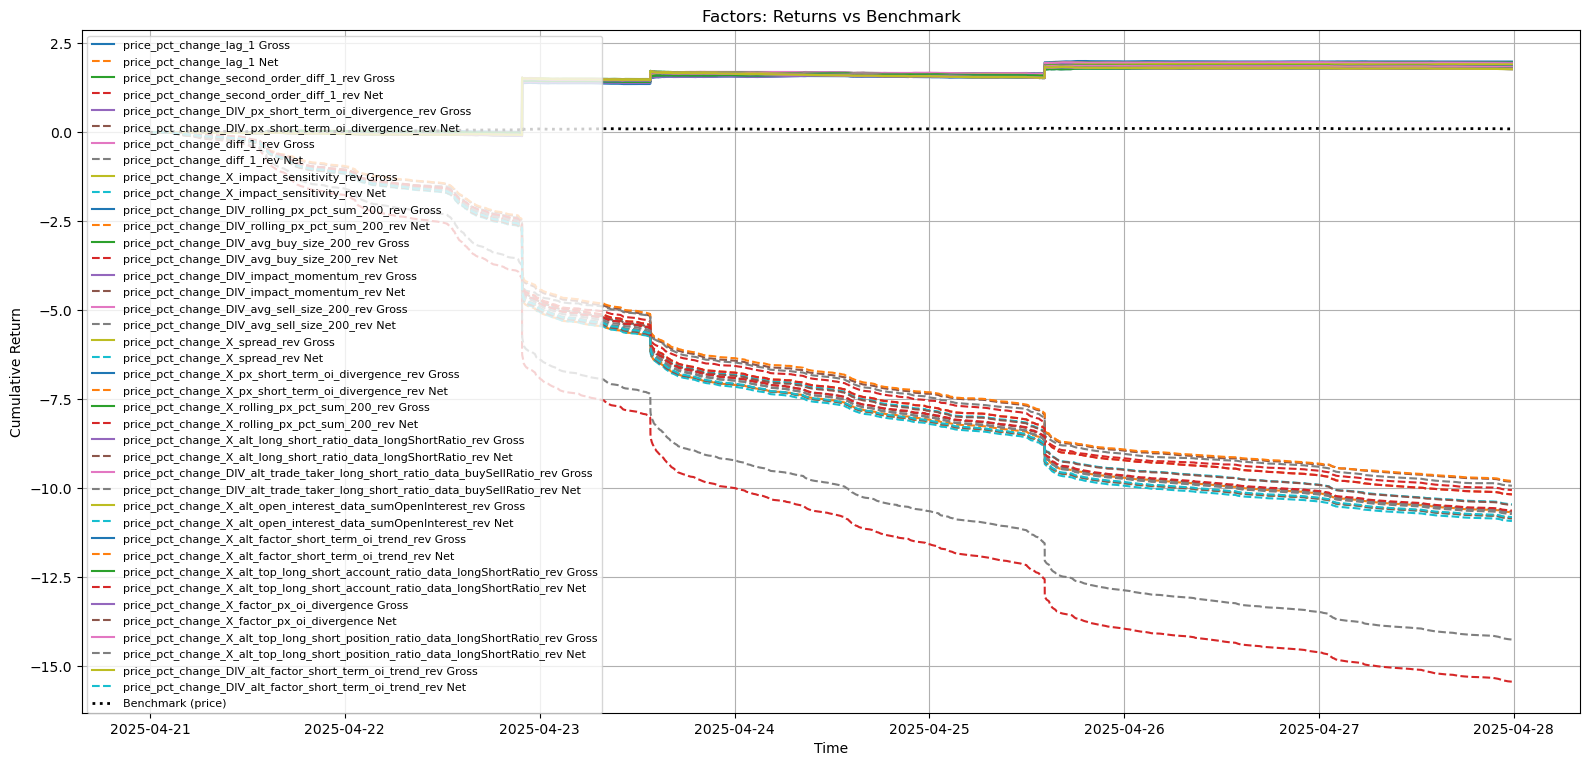

In [686]:
from tqdm import tqdm
import polars as pl
import matplotlib.pyplot as plt

cost_rate = 0.001  # ÂÅáËÆæ‰∫§ÊòìÊàêÊú¨ÊØî‰æãÊòØ0.05%
bug_col = []
# bug_col = ['change_side', 'price_pct_change', 'trades_side', 'ret'
#            , 'orderflow',
#            'divergence', 'impact', 'sum', 'mid', 'price', 'buy_sell', 'factor_momentum_volume',
#             'oi_trend']
exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group'] + bug_col
target_col_for_cal = f"future_return_{avg_steps_2pct}"

# Ëøõ‰∏ÄÊ≠•ÊéíÈô§Â≠óÊÆµÂêç‰∏≠ÂåÖÂê´ bug_col ‰ªª‰Ωï‰∏ÄÈ°π‰Ωú‰∏∫Â≠ê‰∏≤ÁöÑÂ≠óÊÆµ
factors = [
    col for col in df.columns
    if not any(col.startswith(prefix) for prefix in exclude_prefixes)
    and not any(bug in col for bug in bug_col)
    and not col.startswith("future_return")
    and col != "price"
]


def gen_signal_expr(factor, reverse=False):
    q20 = df.select(pl.col(factor).quantile(0.5)).item()
    q80 = df.select(pl.col(factor).quantile(0.5)).item()
    signal_name = f"signal_{factor}_rev" if reverse else f"signal_{factor}"
    signal = (
        pl.when(pl.col(factor) > q80).then(1)
          .when(pl.col(factor) < q20).then(-1)
          .otherwise(0)
          .alias(signal_name)
    )
    if reverse:
        return (signal * -1).alias(signal_name)
    return signal


# signal_exprs = []
# for f in factors:
#     signal_exprs.append(gen_signal_expr(f, reverse=False))
#     signal_exprs.append(gen_signal_expr(f, reverse=True))

df_cum_sum = gen_signal_exprs_rolling(df, factors, window_size=500)
print(df_cum_sum)

for f in tqdm(factors, desc="Calculating strategy returns"):
    signal_col = f"signal_{f}"

    for mode in ["", "_rev"]:  # Á©∫Â≠óÁ¨¶‰∏≤ÊòØÊ≠£ÂêëÔºå_rev ÊòØÂèçÂêë
        signal_col = f"signal_{f}{mode}"
        strategy_return_col = f"strategy_return_{f}{mode}"
        cum_return_col = f"cum_strategy_return_{f}{mode}"
   
        df_cum_sum = df_cum_sum.with_columns([
            (pl.col(signal_col) * (pl.col("price").shift(-1) / pl.col("price") - 1)).alias(strategy_return_col)
        ]).with_columns([
            pl.col(strategy_return_col).fill_null(0).cum_sum().alias(cum_return_col)
        ])

for f in tqdm(factors, desc="Calculating costs and net returns"):
      for mode in ["", "_rev"]:
        signal_col = f"signal_{f}{mode}"
        strategy_return_col = f"strategy_return_{f}{mode}"

        position_change_col = f"{signal_col}_position_change"
        transaction_cost_col = f"{signal_col}_transaction_cost"
        net_return_col = f"net_return_{f}{mode}"
        cum_net_return_col = f"cum_net_return_{f}{mode}"
    
        df_cum_sum = df_cum_sum.with_columns([
            (pl.col(signal_col).diff().abs().fill_null(0)).alias(position_change_col)
        ])
    
        df_cum_sum = df_cum_sum.with_columns([
            (pl.col(position_change_col) * cost_rate).alias(transaction_cost_col)
        ])
    
        df_cum_sum = df_cum_sum.with_columns([
            (pl.col(strategy_return_col) - pl.col(transaction_cost_col)).alias(net_return_col)
        ])
    
        df_cum_sum = df_cum_sum.with_columns([
            pl.col(net_return_col).fill_null(0).cum_sum().alias(cum_net_return_col)
        ])

    
time = df_cum_sum["timestamp_dt"] if "timestamp_dt" in df_cum_sum.columns else df_cum_sum.select(pl.arange(0, df_cum_sum.height)).to_series()

PLOT_POSITIVE_ONLY = False

exclude_factors = ["signal"]
net_return_cols = [f"cum_net_return_{f}" for f in factors] + [f"cum_net_return_{f}_rev" for f in factors]
gross_return_cols = [f"cum_strategy_return_{f}" for f in factors] + [f"cum_strategy_return_{f}_rev" for f in factors]

# ÊéíÈô§‰∏çÈúÄË¶ÅÁöÑÂõ†Â≠ê
net_return_cols = [
    col for col in net_return_cols
    if not any(excl in col for excl in exclude_factors)
]

gross_return_cols = [
    col for col in gross_return_cols
    if not any(excl in col for excl in exclude_factors)
]

final_gross_returns = df_cum_sum.select(gross_return_cols).tail(1).to_dict(as_series=False)

# Ëé∑ÂèñÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥ÁÇπÁöÑÂáÄÊî∂ÁõäÂÄº
final_net_returns = df_cum_sum.select(net_return_cols).tail(1).to_dict(as_series=False)

# Ê†πÊçÆÊúÄÂêéÊî∂ÁõäÊéíÂ∫è
sorted_net_returns = sorted(final_gross_returns.items(), key=lambda x: x[1][0], reverse=True)
top20 = sorted_net_returns[:20]
topN_info = []
good_factors = []

for col_name, value in top20:
    is_reversed = col_name.endswith("_rev")
    # ÂéªÊéâÂâçÁºÄÂíå _rev ÂêéÁºÄÔºåÂæóÂà∞Á∫ØÂáÄÂõ†Â≠êÂêç
    clean_name = col_name.replace("cum_net_return_", "")
    if is_reversed:
        clean_name = clean_name.replace("_rev", "")
    topN_info.append({
        "raw_col": col_name,
        "factor": clean_name,
        "is_reversed": is_reversed,
        "final_return": value[0]
    })
    good_factors.append(clean_name)
    
print(top20)
# ÊèêÂèñÂàóÂêç„ÄÅÊòØÂê¶ÂèçËΩ¨ÁöÑÊ†áÂøó
# top20_info = []
# for col_name, value in top20:
#     if col_name.endswith("_rev"):
#         factor_name = col_name.removeprefix("cum_net_return_").removesuffix("_rev")
#         is_rev = True
#     else:
#         factor_name = col_name.removeprefix("cum_net_return_")
#         is_rev = False
#     top20_info.append((factor_name, is_rev))
top20_info = []
for col_name, value in top20:
    if col_name.endswith("_rev"):
        factor_name = col_name.removeprefix("cum_strategy_return_").removesuffix("_rev")
        is_rev = True
    else:
        factor_name = col_name.removeprefix("cum_strategy_return_")
        is_rev = False
    top20_info.append((factor_name, is_rev))
# ÂºÄÂßãÁîªÂõæ
plt.figure(figsize=(16, 8))
step = 10

for f, is_rev in top20_info:
    suffix = "_rev" if is_rev else ""
    gross_col = f"cum_strategy_return_{f}{suffix}"
    net_col = f"cum_net_return_{f}{suffix}"
    signal_col = f"signal_{f}{suffix}"

    # Ê£ÄÊü•ÂàóÊòØÂê¶Â≠òÂú®
    if gross_col not in df_cum_sum.columns or net_col not in df_cum_sum.columns:
        print(f"‚ö†Ô∏è Missing column for factor {f} (rev={is_rev})")
        continue

    # Ëé∑ÂèñÊï∞ÊçÆ
    gross_arr = df_cum_sum[gross_col].to_numpy()
    net_arr = df_cum_sum[net_col].to_numpy()

    if PLOT_POSITIVE_ONLY:
        gross_arr = np.clip(gross_arr, a_min=0, a_max=None)
        net_arr = np.clip(net_arr, a_min=0, a_max=None)

    # ÊâìÂç∞‰ø°ÊÅØ
    print(f"\n==== Factor: {f}{'_rev' if is_rev else ''} ====")
    print("Net return head:", net_arr[:5])
    print("Net return tail:", net_arr[-5:])
    print("Net return max:", net_arr.max())
    print("Net return min:", net_arr.min())
    print("Final return:", net_arr[-1])
    
    time_sampled = time[::step]
    gross_arr_sampled = gross_arr[::step]
    net_arr_sampled = net_arr[::step]
    # ÁîªÂõæ
    plt.plot(time_sampled, gross_arr_sampled, label=f"{f}{suffix} Gross", linestyle="-")
    plt.plot(time_sampled, net_arr_sampled, label=f"{f}{suffix} Net", linestyle="--")

# benchmark ‰πüÈááÊ†∑‰∏Ä‰∏ã
price_return_arr = (df_cum_sum["price"] / df_cum_sum["price"].shift(1) - 1).fill_null(0).to_numpy()
cum_price_return = np.cumsum(price_return_arr)
cum_price_return_sampled = cum_price_return[::step]
plt.plot(time_sampled, cum_price_return_sampled, label="Benchmark (price)", color="black", linewidth=2, linestyle=":")

plt.title("Factors: Returns vs Benchmark")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [642]:
# Ê†∑‰æãÊï∞ÊçÆ
values = [10, 20, 30, 40, 50]
import pandas as pd

df_pd = pd.DataFrame({"value": values})
df_pd["shift_1"] = df_pd["value"].shift(1)
import polars as pl

df_pl = pl.DataFrame({"value": values})
df_pl = df_pl.with_columns(
    shift_1 = pl.col("value").shift(1)
)

df_pd["rolling_3"] = df_pd["value"].rolling(3).mean()
df_pl = df_pl.with_columns(
    rolling_3 = pl.col("value").rolling_mean(window_size=3)
)
df_pl = df_pl.with_columns(
    lag_2 = pl.col("value").shift(2)
)
print("üì¶ Pandas:")
print(df_pd)

print("\nüì¶ Polars:")
print(df_pl)


üì¶ Pandas:
   value  shift_1  rolling_3
0     10      NaN        NaN
1     20     10.0        NaN
2     30     20.0       20.0
3     40     30.0       30.0
4     50     40.0       40.0

üì¶ Polars:
shape: (5, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ value ‚îÜ shift_1 ‚îÜ rolling_3 ‚îÜ lag_2 ‚îÇ
‚îÇ ---   ‚îÜ ---     ‚îÜ ---       ‚îÜ ---   ‚îÇ
‚îÇ i64   ‚îÜ i64     ‚îÜ f64       ‚îÜ i64   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 10    ‚îÜ null    ‚îÜ null      ‚îÜ null  ‚îÇ
‚îÇ 20    ‚îÜ 10      ‚îÜ null      ‚îÜ null  ‚îÇ
‚îÇ 30    ‚îÜ 20      ‚îÜ 20.0      ‚îÜ 10    ‚îÇ
‚îÇ 40    ‚îÜ 30      ‚îÜ 30.0      ‚îÜ 20    ‚îÇ
‚îÇ 50    ‚îÜ 40      ‚îÜ 40.0      ‚îÜ 30    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


In [658]:
import polars as pl

# === Ê®°ÊãüÊï∞ÊçÆ ===
df = pl.DataFrame({
    "price": [100, 101, 102, 101, 100, 98, 99, 100],
    "signal": [0, 1, 1, 0, -1, -1, 0, 1],  # È¢ÑËÆæÁöÑ‰ø°Âè∑
})

# === ËÆæÁΩÆÂèÇÊï∞ ===
cost_rate = 0.001  # ÂÅáËÆæ‰∫§ÊòìÊàêÊú¨‰∏∫ 0.1%

# === ËÆ°ÁÆóÁ≠ñÁï•Êî∂Áõä ===
df = df.with_columns([
    # Êî∂Áõä = ÂΩìÊúü signal √ó (‰∏ãÊúü‰ª∑Ê†ºÂèòÂåñ)
    (pl.col("signal") * (pl.col("price").shift(-1) / pl.col("price") - 1)).alias("strategy_return"),
    
    # ‰ªì‰ΩçÂèòÂåñÔºàÁªùÂØπÂÄºÔºâÁî®‰∫éËÆ°ÁÆóÊç¢‰ªìÊàêÊú¨
    pl.col("signal").diff().abs().fill_null(0).alias("position_change"),
])

df = df.with_columns([
    # ÊàêÊú¨ = position_change √ó ÊàêÊú¨Áéá
    (pl.col("position_change") * cost_rate).alias("transaction_cost"),
    ]).with_columns([

    # ÂáÄÊî∂Áõä = Á≠ñÁï•Êî∂Áõä - ÊàêÊú¨
    (pl.col("strategy_return") - pl.col("transaction_cost")).alias("net_return"),
    
    # Á¥ØËÆ°Êî∂Áõä
    pl.col("strategy_return").fill_null(0).cum_sum().alias("cum_strategy_return"),
    ]).with_columns([
    pl.col("net_return").fill_null(0).cum_sum().alias("cum_net_return"),
])

# === ÊâìÂç∞ÁªìÊûú ===
print(df)


shape: (8, 8)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ price ‚îÜ signal ‚îÜ strategy_return ‚îÜ position_change ‚îÜ transaction_cost ‚îÜ net_return ‚îÜ cum_strategy_return ‚îÜ cum_net_return ‚îÇ
‚îÇ ---   ‚îÜ ---    ‚îÜ ---             ‚îÜ ---             ‚îÜ ---              ‚îÜ ---        ‚îÜ ---                 ‚îÜ ---            ‚îÇ
‚îÇ i64   ‚îÜ i64    ‚îÜ f64             ‚îÜ i64             ‚îÜ f64              ‚îÜ f64        ‚îÜ f64                 ‚îÜ f64            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚

[('cum_net_return_oi_trend_slope_skew_rev', [0.032373364403002765]), ('cum_net_return_alt_factor_long_term_oi_trend_fft_power_top3', [0.02036203223231048]), ('cum_net_return_alt_open_interest_data_sumOpenInterestValue_fft_power_top3_rev', [0.01993097943875667]), ('cum_net_return_alt_top_long_short_account_ratio_data_longShortRatio_kalman', [0.01457226884997034]), ('cum_net_return_alt_factor_long_term_oi_trend_kalman', [0.0021943700148128274])]

==== Factor: oi_trend_slope_skew_rev ====
Net return head: [0. 0. 0. 0. 0.]
Net return tail: [0.03237336 0.03237336 0.03237336 0.03237336 0.03237336]
Net return max: 0.06129068559489293
Net return min: -0.006942060529740445
Final return: 0.032373364403002765

==== Factor: alt_factor_long_term_oi_trend_fft_power_top3 ====
Net return head: [0. 0. 0. 0. 0.]
Net return tail: [0.01978521 0.02034256 0.02086226 0.02036203 0.02036203]
Net return max: 0.0466726211264199
Net return min: -0.025151284025671017
Final return: 0.02036203223231048

==== Factor:

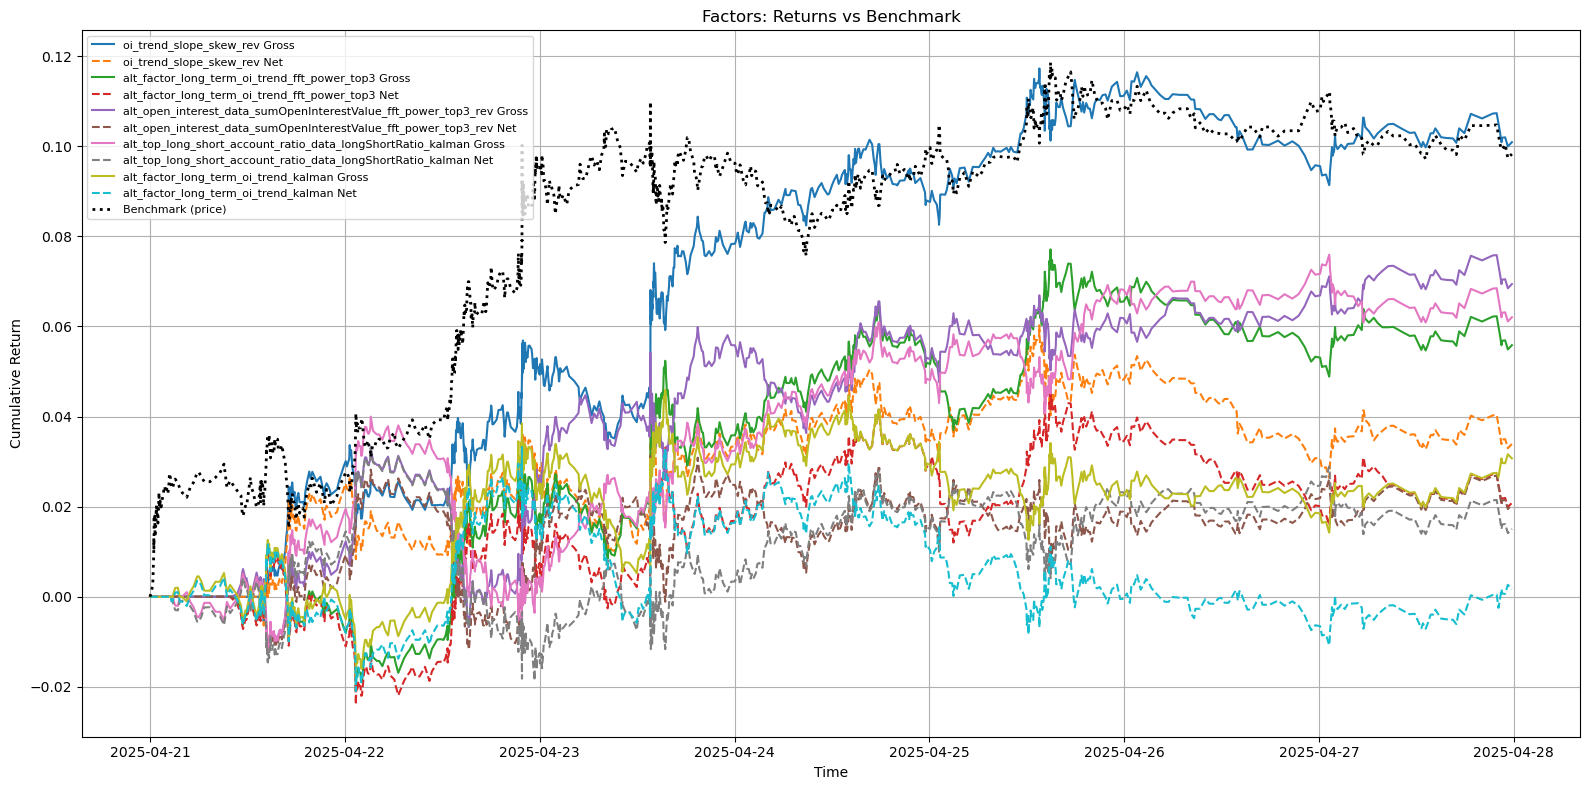

In [688]:

    
time = df_cum_sum["timestamp_dt"] if "timestamp_dt" in df_cum_sum.columns else df_cum_sum.select(pl.arange(0, df_cum_sum.height)).to_series()

PLOT_POSITIVE_ONLY = False

exclude_factors = ["signal"]
net_return_cols = [f"cum_net_return_{f}" for f in factors] + [f"cum_net_return_{f}_rev" for f in factors]
gross_return_cols = [f"cum_strategy_return_{f}" for f in factors] + [f"cum_strategy_return_{f}_rev" for f in factors]

# ÊéíÈô§‰∏çÈúÄË¶ÅÁöÑÂõ†Â≠ê
net_return_cols = [
    col for col in net_return_cols
    if not any(excl in col for excl in exclude_factors)
]

gross_return_cols = [
    col for col in gross_return_cols
    if not any(excl in col for excl in exclude_factors)
]

final_gross_returns = df_cum_sum.select(gross_return_cols).tail(1).to_dict(as_series=False)

# Ëé∑ÂèñÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥ÁÇπÁöÑÂáÄÊî∂ÁõäÂÄº
final_net_returns = df_cum_sum.select(net_return_cols).tail(1).to_dict(as_series=False)

# Ê†πÊçÆÊúÄÂêéÊî∂ÁõäÊéíÂ∫è
sorted_net_returns = sorted(final_net_returns.items(), key=lambda x: x[1][0], reverse=True)
top20 = sorted_net_returns[:5]
topN_info = []
good_factors = []

for col_name, value in top20:
    is_reversed = col_name.endswith("_rev")
    # ÂéªÊéâÂâçÁºÄÂíå _rev ÂêéÁºÄÔºåÂæóÂà∞Á∫ØÂáÄÂõ†Â≠êÂêç
    clean_name = col_name.replace("cum_net_return_", "")
    if is_reversed:
        clean_name = clean_name.replace("_rev", "")
    topN_info.append({
        "raw_col": col_name,
        "factor": clean_name,
        "is_reversed": is_reversed,
        "final_return": value[0]
    })
    good_factors.append(clean_name)
    
print(top20)
# ÊèêÂèñÂàóÂêç„ÄÅÊòØÂê¶ÂèçËΩ¨ÁöÑÊ†áÂøó
top20_info = []
for col_name, value in top20:
    if col_name.endswith("_rev"):
        factor_name = col_name.removeprefix("cum_net_return_").removesuffix("_rev")
        is_rev = True
    else:
        factor_name = col_name.removeprefix("cum_net_return_")
        is_rev = False
    top20_info.append((factor_name, is_rev))
# top20_info = []
# for col_name, value in top20:
#     if col_name.endswith("_rev"):
#         factor_name = col_name.removeprefix("cum_strategy_return_").removesuffix("_rev")
#         is_rev = True
#     else:
#         factor_name = col_name.removeprefix("cum_strategy_return_")
#         is_rev = False
#     top20_info.append((factor_name, is_rev))
# ÂºÄÂßãÁîªÂõæ
plt.figure(figsize=(16, 8))
step = 10

for f, is_rev in top20_info:
    suffix = "_rev" if is_rev else ""
    gross_col = f"cum_strategy_return_{f}{suffix}"
    net_col = f"cum_net_return_{f}{suffix}"
    signal_col = f"signal_{f}{suffix}"

    # Ê£ÄÊü•ÂàóÊòØÂê¶Â≠òÂú®
    if gross_col not in df_cum_sum.columns or net_col not in df_cum_sum.columns:
        print(f"‚ö†Ô∏è Missing column for factor {f} (rev={is_rev})")
        continue

    # Ëé∑ÂèñÊï∞ÊçÆ
    gross_arr = df_cum_sum[gross_col].to_numpy()
    net_arr = df_cum_sum[net_col].to_numpy()

    if PLOT_POSITIVE_ONLY:
        gross_arr = np.clip(gross_arr, a_min=0, a_max=None)
        net_arr = np.clip(net_arr, a_min=0, a_max=None)

    # ÊâìÂç∞‰ø°ÊÅØ
    print(f"\n==== Factor: {f}{'_rev' if is_rev else ''} ====")
    print("Net return head:", net_arr[:5])
    print("Net return tail:", net_arr[-5:])
    print("Net return max:", net_arr.max())
    print("Net return min:", net_arr.min())
    print("Final return:", net_arr[-1])
    
    time_sampled = time[::step]
    gross_arr_sampled = gross_arr[::step]
    net_arr_sampled = net_arr[::step]
    # ÁîªÂõæ
    plt.plot(time_sampled, gross_arr_sampled, label=f"{f}{suffix} Gross", linestyle="-")
    plt.plot(time_sampled, net_arr_sampled, label=f"{f}{suffix} Net", linestyle="--")

# benchmark ‰πüÈááÊ†∑‰∏Ä‰∏ã
price_return_arr = (df_cum_sum["price"] / df_cum_sum["price"].shift(1) - 1).fill_null(0).to_numpy()
cum_price_return = np.cumsum(price_return_arr)
cum_price_return_sampled = cum_price_return[::step]
plt.plot(time_sampled, cum_price_return_sampled, label="Benchmark (price)", color="black", linewidth=2, linestyle=":")

plt.title("Factors: Returns vs Benchmark")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

In [796]:
import matplotlib.pyplot as plt

def plot_factor_comparison(df, factor_a: str, factor_b: str):
    cum_col_a = factor_a
    cum_col_b = factor_b
    time_col = df.columns[0]  # ÂÅáËÆæÁ¨¨0ÂàóÊòØÊó∂Èó¥Êà≥ÔºåÊØîÂ¶Ç 'timestamp' Êàñ 'date'

    plt.figure(figsize=(12, 6))
    plt.plot(df[time_col], df[cum_col_a], label=factor_a, linewidth=2)
    plt.plot(df[time_col], df[cum_col_b], label=factor_b, linewidth=2, linestyle="--")

    plt.title(f"Cumulative Strategy Return: {factor_a} vs {factor_b}")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_factor_comparison(
    df,
    factor_a="change_side_kalman",
    factor_b="alt_factor_long_term_oi_trend_fft_power_top3"
)


ColumnNotFoundError: "change_side_kalman" not found

<Figure size 1200x600 with 0 Axes>

In [794]:
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd

def plot_rolling_vs_global_quantile_from_polars(
    pl_df: pl.DataFrame,
    factor: str,
    window: int = 50,
    quantiles=(0.1, 0.5, 0.9),
    global_colors=("red", "green", "blue"),  # ÊØè‰∏™ global quantile Áî®‰∏çÂêåÈ¢úËâ≤
    rolling_colors=("orange", "lime", "cyan")  # ÂèØËá™ÂÆö‰πâ rolling Á∫øÈ¢úËâ≤
):
    # ËΩ¨Êàê pandas
    df = pl_df.to_pandas()
    time_col = df.columns[0]
    x = df[time_col]
    y = df[factor]

    plt.figure(figsize=(14, 6))
    plt.plot(x, y, label=factor, color="black", alpha=0.4)

    # global quantiles Ê®™Á∫ø
    for i, q in enumerate(quantiles):
        q_val = y.quantile(q)
        plt.axhline(q_val, linestyle='--', color=global_colors[i], alpha=0.7,
                    label=f'Global Q{q:.1f}: {q_val:.2f}')

    # rolling quantiles Êõ≤Á∫ø
    for i, q in enumerate(quantiles):
        rolling_q = y.rolling(window=window).quantile(q)
        plt.plot(x, rolling_q, label=f'Rolling Q{q:.1f}', linewidth=2, color=rolling_colors[i])

    plt.title(f"{factor}: Rolling vs Global Quantiles (window={window})")
    plt.xlabel("Time")
    plt.ylabel("Factor Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_rolling_vs_global_quantile_from_polars(
    pl_df=df,
    factor="change_side_kalman",
    window=500,
    quantiles=(0.1, 0.5, 0.9),
    global_colors=("red", "green", "blue"),
    rolling_colors=("pink", "lime", "skyblue")
)


KeyError: 'change_side_kalman'

In [254]:
import numpy as np

def sharpe_ratio_non_annualized(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1)
    if std_excess_return == 0:
        return np.nan
    return mean_excess_return / std_excess_return


In [698]:
def gen_signal_exprs_rolling(df: pl.DataFrame, factors: list[str], window_size=500):
    exprs_group_a = []
    exprs_group_b = []

    for factor in factors:
        up_temp = f"{factor}_up_temp"
        dn_temp = f"{factor}_dn_temp"

        # ËÆ°ÁÆó rolling quantiles
        exprs_group_a.extend([
            pl.col(factor).rolling_quantile(0.51, "nearest", window_size).alias(up_temp),
            pl.col(factor).rolling_quantile(0.49, "nearest", window_size).alias(dn_temp),
        ])

        # Ê≠£Âêë signal
        signal_col = f"signal_{factor}"
        exprs_group_b.append(
            pl.when(pl.col(factor) > pl.col(up_temp)).then(1)
            .when(pl.col(factor) < pl.col(dn_temp)).then(-1)
            .otherwise(0)
            .fill_null(0)
            .alias(signal_col)
        )

        # ÂèçÂêë signal
        signal_rev_col = f"signal_{factor}_rev"
        exprs_group_b.append(
            pl.when(pl.col(factor) > pl.col(up_temp)).then(-1)
            .when(pl.col(factor) < pl.col(dn_temp)).then(1)
            .otherwise(0)
            .fill_null(0)
            .alias(signal_rev_col)
        )

    df = df.with_columns(exprs_group_a).with_columns(exprs_group_b)
    
    drop_cols = [f"{factor}_up_temp" for factor in factors] + [f"{factor}_dn_temp" for factor in factors]
    df = df.drop(drop_cols)

    return df

xs = gen_signal_exprs_rolling(df, factors, window_size=500)
print(xs)

shape: (11_757, 10_837)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ price   ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ signal_oi_long_breakout_signal‚Ä¶ ‚îÜ signal_oi_long_breakout_signal‚Ä¶ ‚îÜ signal_oi_long_breakout_signal‚Ä¶ ‚îÜ signal_oi_long_breakout_signal‚Ä¶ ‚îÇ
‚îÇ ---              ‚îÜ ---     ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ ---                             ‚îÜ ---                       

In [734]:
def gen_signal_expr(factor, reverse=False):
    q20 = df.select(pl.col(factor).quantile(0.8)).item()
    q80 = df.select(pl.col(factor).quantile(0.2)).item()
    signal_name = f"signal_{factor}_rev" if reverse else f"signal_{factor}"
    signal = (
        pl.when(pl.col(factor) > q80).then(1)
          .when(pl.col(factor) < q20).then(-1)
          .otherwise(0)
          .alias(signal_name)
    )
    if reverse:
        return (signal * -1).alias(signal_name)
    return signal


signal_exprs = []
for f in factors:
    signal_exprs.append(gen_signal_expr(f, reverse=False))
    signal_exprs.append(gen_signal_expr(f, reverse=True))

xs = df.with_columns(signal_exprs)
print(xs)

shape: (11_757, 8_765)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ price   ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ signal_impact_sensitivity_DIV_‚Ä¶ ‚îÜ signal_impact_sensitivity_DIV_‚Ä¶ ‚îÜ signal_impact_sensitivity_SPRE‚Ä¶ ‚îÜ signal_impact_sensitivity_SPRE‚Ä¶ ‚îÇ
‚îÇ ---              ‚îÜ ---     ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ ---                             ‚îÜ ---                        

In [758]:
def compute_signals_and_returns(df: pl.DataFrame, factors: list[str], cost_rate=0.0005) -> pl.DataFrame:
    signal_exprs = []

    # ‚úÖ ‰∏ÄÊ¨°ÊÄßÁîüÊàêÊâÄÊúâ‰ø°Âè∑Ë°®ËææÂºè
    for f in factors:
        signal_exprs += [gen_signal_expr(f, False), gen_signal_expr(f, True)]

    # ‚úÖ ‰∏ÄÊ¨°ÊÄßÊ∑ªÂä†ÊâÄÊúâ signal Âàó
    df = df.with_columns(signal_exprs)

    # ‚úÖ ÂØπÊØè‰∏™Âõ†Â≠êÔºàÊ≠£Âêë + ÂèçÂêëÔºâÂ§ÑÁêÜÊî∂Áõä„ÄÅÊàêÊú¨Á≠â
    exprs_group_a = []
    exprs_group_b = []
    exprs_group_c = []
    exprs_group_d = []

    for f in tqdm(factors, desc="Computing returns"):
        for mode in ["", "_rev"]:
            signal_col = f"signal_{f}{mode}"
            strat_ret_col = f"strategy_return_{f}{mode}"
            cum_ret_col = f"cum_strategy_return_{f}{mode}"

            pos_change_col = f"{signal_col}_position_change"
            cost_col = f"{signal_col}_transaction_cost"
            net_ret_col = f"net_return_{f}{mode}"
            cum_net_ret_col = f"cum_net_return_{f}{mode}"

            exprs_group_a += [
                (pl.col(signal_col) * (pl.col("price").shift(-1) / pl.col("price") - 1)).alias(strat_ret_col),
                pl.col(signal_col).diff().abs().fill_null(0).alias(pos_change_col),
            ]
            
            exprs_group_b += [
                (pl.col(pos_change_col) * cost_rate).alias(cost_col),
                pl.col(strat_ret_col).fill_null(0).cum_sum().alias(cum_ret_col),
            ]

            exprs_group_c += [
                (pl.col(strat_ret_col) - pl.col(cost_col)).alias(net_ret_col),
            ]
            exprs_group_d += [
                pl.col(net_ret_col).fill_null(0).cum_sum().alias(cum_net_ret_col),

            ]

    # ‚úÖ ‰∏ÄÊ¨°ÊÄßÂ∫îÁî®ÊâÄÊúâË°®ËææÂºè
    df = df.with_columns(exprs_group_a).with_columns(exprs_group_b).with_columns(exprs_group_c).with_columns(exprs_group_d)

    return df

In [736]:
def rank_factors_by_gross(df: pl.DataFrame, factors: list[str], plot_top_n=20, sort_by="final_return"):
    factor_stats = []
    for f in tqdm(factors, desc="Ranking factors by gross return"):
        for mode in ["", "_rev"]:
            suffix = f"{f}{mode}"
            cum_gross_col = f"cum_net_return_{suffix}"
            if cum_gross_col not in df.columns:
                continue
            cum_returns = df[cum_gross_col].to_numpy()
            if len(cum_returns) < 2:
                continue
            sharpe = sharpe_ratio_non_annualized(np.diff(cum_returns, prepend=0))
            final_return = cum_returns[-1]
            factor_stats.append({
                "factor": f,
                "mode": mode,
                "gross_col": cum_gross_col,
                "sharpe": sharpe,
                "final_return": final_return,
            })

    sorted_stats = sorted(factor_stats, key=lambda x: x[sort_by], reverse=True)
    top_stats = sorted_stats[:plot_top_n]

    top_factors_by_gross = [f"{item['factor']}{item['mode']}" for item in top_stats]
    sharpe_by_factor = {f"{item['factor']}{item['mode']}": item["sharpe"] for item in top_stats}
    gross_by_factor = {f"{item['factor']}{item['mode']}": item["final_return"] for item in top_stats}

    return top_factors_by_gross, sharpe_by_factor, gross_by_factor


In [737]:
bug_col = [
    "strategy_return_", "cum_strategy_return_", "signal_",
    "position_", "position_change_", "sharpe_", "gross_", "net_",
    "price_pct_change", "ret_1", "change_side", "momentum_confirmed_by_orderflow",
    "trades_side",
    
]

exclude_contains = [
    "ret_mean_10", "ret_mean_5", "ret_1_lag",
    "position_", "position_change_", "sharpe_", "gross_", "net_",
    "price_pct_change", "ret_1", "change_side",
    "momentum_confirmed_by_orderflow", "trades_side",
    "rolling_px_pct_sum", "px_short_oi_divergence"
]

exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group'] + bug_col
target_col_for_cal = f"future_return_{avg_steps_2pct}"

# Ëøõ‰∏ÄÊ≠•ÊéíÈô§Â≠óÊÆµÂêç‰∏≠ÂåÖÂê´ bug_col ‰ªª‰Ωï‰∏ÄÈ°π‰Ωú‰∏∫Â≠ê‰∏≤ÁöÑÂ≠óÊÆµ
factors = [
    col for col in df.columns
    if not any(col.startswith(prefix) for prefix in exclude_prefixes)
    and not any(bug in col for bug in bug_col)
    and not col.startswith("future_return")
    and not col.startswith("signal_")
    and not col.startswith("momentum_confirmed_by_orderflow")
    and not col.startswith("ret_mean_5")
    and not col.startswith("ret_mean_10")
    and not any(keyword in col for keyword in exclude_contains)

    and col != "price"
]

df_with_signals = gen_signal_exprs_rolling(df, factors, window_size=500)
print(df_with_signals)

df_cum_sum = compute_signals_and_returns(df_with_signals, factors)
top_factors_by_gross, sharpe_by_factor, gross_by_factor = rank_factors_by_gross(df_cum_sum, factors)

print("Top Factors by Gross Return:", top_factors_by_gross, sharpe_by_factor, gross_by_factor)
print("Sharpe Ratios (non-annualized):")
for k, v in sharpe_by_factor.items():
    print(f"{k}: {v:.4f}")


shape: (11_757, 8_765)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ timestamp        ‚îÜ price   ‚îÜ sum_buy_size ‚îÜ sum_sell_size ‚îÜ ‚Ä¶ ‚îÜ signal_impact_sensitivity_DIV_‚Ä¶ ‚îÜ signal_impact_sensitivity_DIV_‚Ä¶ ‚îÜ signal_impact_sensitivity_SPRE‚Ä¶ ‚îÜ signal_impact_sensitivity_SPRE‚Ä¶ ‚îÇ
‚îÇ ---              ‚îÜ ---     ‚îÜ ---          ‚îÜ ---           ‚îÜ   ‚îÜ ---                             ‚îÜ ---                        

Ranking factors by gross return: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2521/2521 [00:14<00:00, 171.51it/s]

Top Factors by Gross Return: ['real_bid_amount_sum_volatility_200', 'alt_open_interest_data_sumOpenInterest_DIV_alt_open_interest_data_sumOpenInterestValue', 'alt_top_long_short_account_ratio_data_longShortRatio_X_oi_trend_slope', 'best_bid_amount_fft_power_top3', 'alt_long_short_ratio_data_longShortRatio_X_oi_trend_slope', 'best_bid_amount_volatility_200', 'alt_trade_taker_long_short_ratio_data_buySellRatio_X_avg_buy_size_200', 'avg_buy_size_200_kalman', 'best_bid_amount_kalman', 'avg_buy_size_200_X_avg_sell_size_200', 'alt_open_interest_data_sumOpenInterestValue_X_avg_buy_size_200', 'avg_buy_size_200_lag_1', 'alt_open_interest_data_sumOpenInterest_X_avg_sell_size_200', 'alt_top_long_short_account_ratio_data_longShortRatio_X_avg_sell_size_200', 'alt_long_short_ratio_data_longShortRatio_X_avg_sell_size_200', 'avg_buy_size_200', 'avg_buy_size_200_squared', 'avg_buy_size_200_abs', 'avg_buy_size_200_SPREAD_X_MAG_px_short_term_oi_divergence', 'avg_buy_size_200_SPREAD_X_MAG_impact_sensitivi

In [738]:
print("Top Factors by Gross Return:", top_factors_by_gross)
print("Sharpe Ratios (non-annualized):")

for k, v in sharpe_by_factor.items():
    print(f"{k}: {v:.4f}")

print("============================")
for k, v in gross_by_factor.items():
    print(f"{k}: {v:.4f}")


Top Factors by Gross Return: ['real_bid_amount_sum_volatility_200', 'alt_open_interest_data_sumOpenInterest_DIV_alt_open_interest_data_sumOpenInterestValue', 'alt_top_long_short_account_ratio_data_longShortRatio_X_oi_trend_slope', 'best_bid_amount_fft_power_top3', 'alt_long_short_ratio_data_longShortRatio_X_oi_trend_slope', 'best_bid_amount_volatility_200', 'alt_trade_taker_long_short_ratio_data_buySellRatio_X_avg_buy_size_200', 'avg_buy_size_200_kalman', 'best_bid_amount_kalman', 'avg_buy_size_200_X_avg_sell_size_200', 'alt_open_interest_data_sumOpenInterestValue_X_avg_buy_size_200', 'avg_buy_size_200_lag_1', 'alt_open_interest_data_sumOpenInterest_X_avg_sell_size_200', 'alt_top_long_short_account_ratio_data_longShortRatio_X_avg_sell_size_200', 'alt_long_short_ratio_data_longShortRatio_X_avg_sell_size_200', 'avg_buy_size_200', 'avg_buy_size_200_squared', 'avg_buy_size_200_abs', 'avg_buy_size_200_SPREAD_X_MAG_px_short_term_oi_divergence', 'avg_buy_size_200_SPREAD_X_MAG_impact_sensitivi

‚ö†Ô∏è Missing column for factor cum_net_return_real_bid_amount_sum_volatility_200 (rev=False)
‚ö†Ô∏è Missing column for factor cum_net_return_alt_open_interest_data_sumOpenInterest_DIV_alt_open_interest_data_sumOpenInterestValue (rev=False)
‚ö†Ô∏è Missing column for factor cum_net_return_alt_top_long_short_account_ratio_data_longShortRatio_X_oi_trend_slope (rev=False)
‚ö†Ô∏è Missing column for factor cum_net_return_best_bid_amount_fft_power_top3 (rev=False)
‚ö†Ô∏è Missing column for factor cum_net_return_alt_long_short_ratio_data_longShortRatio_X_oi_trend_slope (rev=False)


ValueError: x and y must have same first dimension, but have shapes (11757,) and (1176,)

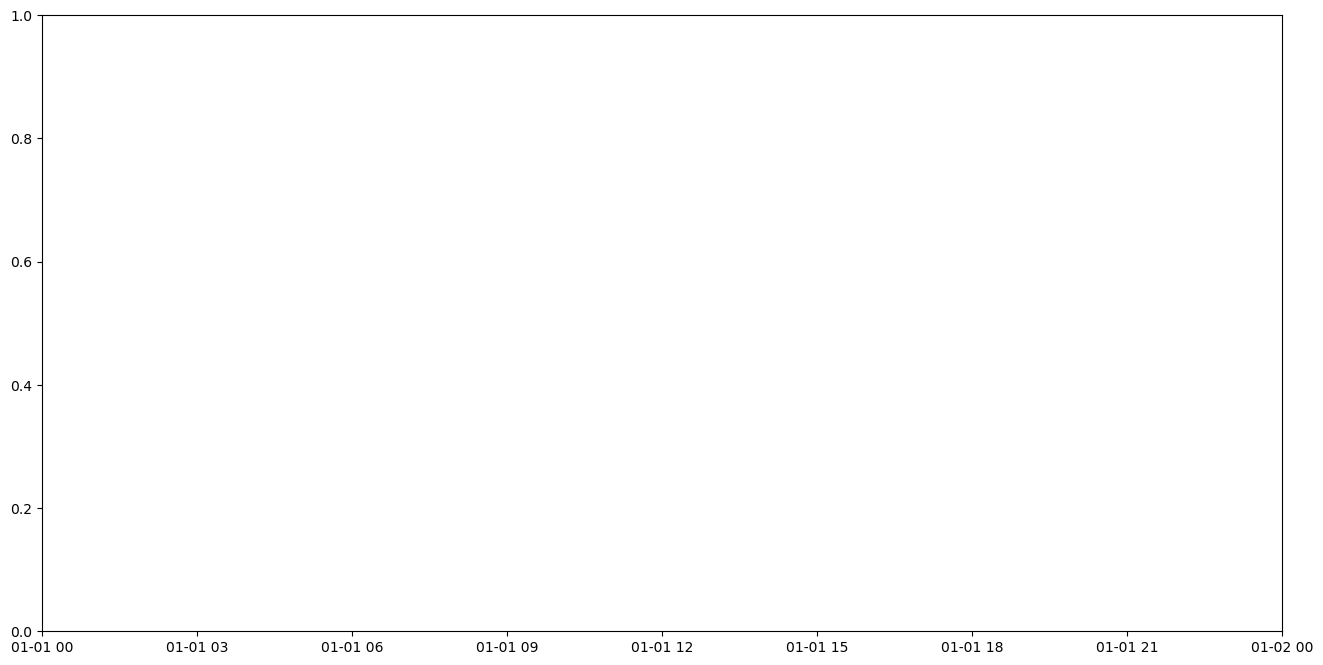

In [770]:

    
time = df_cum_sum["timestamp_dt"] if "timestamp_dt" in df_cum_sum.columns else df_cum_sum.select(pl.arange(0, df_cum_sum.height)).to_series()

PLOT_POSITIVE_ONLY = False

exclude_factors = ["signal"]
net_return_cols = [f"cum_net_return_{f}" for f in factors] + [f"cum_net_return_{f}_rev" for f in factors]
gross_return_cols = [f"strategy_return_{f}" for f in factors] + [f"strategy_return_{f}_rev" for f in factors]

# ÊéíÈô§‰∏çÈúÄË¶ÅÁöÑÂõ†Â≠ê
net_return_cols = [
    col for col in net_return_cols
    if not any(excl in col for excl in exclude_factors)
]

gross_return_cols = [
    col for col in gross_return_cols
    if not any(excl in col for excl in exclude_factors)
]

selected_cols = [
    'cum_net_return_far_ask_price_fft_power_top3',
    'cum_net_return_alt_open_interest_data_sumOpenInterest_DIV_oi_short_breakout_signal_rev',
    'cum_net_return_far_bid_price_fft_power_top3_rev',
    'cum_net_return_mid_price_fft_power_top3_rev',
    'cum_net_return_far_ask_price_fft_power_top3_rev',  # ÂÅáËÆæ‰Ω†ÂàöÂ•ΩË¶ÅËøôÂá†‰∏™
]
df_cum_sum.drop_nulls()

final_gross_returns = df_cum_sum.select(gross_return_cols).tail(1).to_dict(as_series=False)

# Ëé∑ÂèñÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥ÁÇπÁöÑÂáÄÊî∂ÁõäÂÄº
final_net_returns = df_cum_sum.select(net_return_cols).tail(2).to_dict(as_series=False)
# Ê†πÊçÆÊúÄÂêéÊî∂ÁõäÊéíÂ∫è
sorted_net_returns = sorted(final_net_returns.items(), key=lambda x: x[1][0], reverse=True)
top20 = sorted_net_returns[:5]
topN_info = []
good_factors = []

# for col_name, value in top20:
#     is_reversed = col_name.endswith("_rev")
#     # ÂéªÊéâÂâçÁºÄÂíå _rev ÂêéÁºÄÔºåÂæóÂà∞Á∫ØÂáÄÂõ†Â≠êÂêç
#     clean_name = col_name.replace("cum_net_return_", "")
#     if is_reversed:
#         clean_name = clean_name.replace("_rev", "")
#     topN_info.append({
#         "raw_col": col_name,
#         "factor": clean_name,
#         "is_reversed": is_reversed,
#         "final_return": value[0]
#     })
#     good_factors.append(clean_name)
    
# print(top20)
# ÊèêÂèñÂàóÂêç„ÄÅÊòØÂê¶ÂèçËΩ¨ÁöÑÊ†áÂøó
# top20_info = []
# for col_name, value in top20:
#     if col_name.endswith("_rev"):
#         factor_name = col_name.removeprefix("cum_net_return_").removesuffix("_rev")
#         is_rev = True
#     else:
#         factor_name = col_name.removeprefix("cum_net_return_")
#         is_rev = False
#     top20_info.append((factor_name, is_rev))
top20_info = []
for col_name, value in top20:
    if col_name.endswith("_rev"):
        factor_name = col_name.removeprefix("cum_strategy_return_").removesuffix("_rev")
        is_rev = True
    else:
        factor_name = col_name.removeprefix("cum_strategy_return_")
        is_rev = False
    top20_info.append((factor_name, is_rev))

# top20_info = []
# for col_name, value in top20:
#     if col_name.endswith("_rev"):
#         factor_name = col_name.removeprefix("strategy_return_").removesuffix("_rev")
#         is_rev = True
#     else:
#         factor_name = col_name.removeprefix("strategy_return_")
#         is_rev = False
#     top20_info.append((factor_name, is_rev))
# ÂºÄÂßãÁîªÂõæ
# ÂºÄÂßãÁîªÂõæ
plt.figure(figsize=(16, 8))
step = 10

for f, is_rev in top20_info:
    suffix = "_rev" if is_rev else ""
    gross_col = f"strategy_return_{f}{suffix}"
    net_col = f"cum_net_return_{f}{suffix}"
    signal_col = f"signal_{f}{suffix}"

    # Ê£ÄÊü•ÂàóÊòØÂê¶Â≠òÂú®
    if gross_col not in df_cum_sum.columns or net_col not in df_cum_sum.columns:
        print(f"‚ö†Ô∏è Missing column for factor {f} (rev={is_rev})")
        continue

    # Ëé∑ÂèñÊï∞ÊçÆ
    gross_arr = df_cum_sum[gross_col].to_numpy()
    net_arr = df_cum_sum[net_col].to_numpy()

    if PLOT_POSITIVE_ONLY:
        gross_arr = np.clip(gross_arr, a_min=0, a_max=None)
        net_arr = np.clip(net_arr, a_min=0, a_max=None)

    # ÊâìÂç∞‰ø°ÊÅØ
    print(f"\n==== Factor: {f}{'_rev' if is_rev else ''} ====")
    print("Net return head:", net_arr[:5])
    print("Net return tail:", net_arr[-5:])
    print("Net return max:", net_arr.max())
    print("Net return min:", net_arr.min())
    print("Final return:", net_arr[-1])
    
    time_sampled = time[::step]
    gross_arr_sampled = gross_arr[::step]
    net_arr_sampled = net_arr[::step]
    # ÁîªÂõæ
    plt.plot(time_sampled, gross_arr_sampled, label=f"{f}{suffix} Gross", linestyle="-")
    plt.plot(time_sampled, net_arr_sampled, label=f"{f}{suffix} Net", linestyle="--")

# benchmark ‰πüÈááÊ†∑‰∏Ä‰∏ã
price_return_arr = (df_cum_sum["price"] / df_cum_sum["price"].shift(1) - 1).fill_null(0).to_numpy()
cum_price_return = np.cumsum(price_return_arr)
cum_price_return_sampled = cum_price_return[::step]
plt.plot(time_sampled, cum_price_return_sampled, label="Benchmark (price)", color="black", linewidth=2, linestyle=":")

plt.title("Factors: Returns vs Benchmark")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


==== Factor: impact_price_pct_bid_imn ====
Net return head: [ 5.28243415e-04  1.03210163e-03  5.29164500e-04  2.41311974e-05
 -5.15864271e-04]
Net return tail: [-4.33185624 -4.33341359 -4.33393328 -4.33343306 -4.33443306]
Final net return: -4.334433061356983
Signal √ó Price return tail: [-2.07336183 -2.07284212 -2.07339947 -2.07391916 -2.07441939]
Final signal √ó price return: -2.074419387942087

==== Factor: spread ====
Net return head: [-0.00052824 -0.00102439 -0.00152732 -0.00203236 -0.00257235]
Net return tail: [-3.38576254 -3.38631989 -3.38683958 -3.38633936 -3.38633936]
Final net return: -3.386339357123177
Signal √ó Price return tail: [0.02118961 0.02170932 0.02115197 0.02063228 0.0211325 ]
Final signal √ó price return: 0.021132502829651734

==== Factor: best_ask_amount ====
Net return head: [-0.00052824 -0.0010321  -0.00052916 -0.0020342  -0.0024942 ]
Net return tail: [-3.01755602 -3.01699867 -3.01851836 -3.01801814 -3.01901814]
Final net return: -3.0190181367501485
Signal √ó P

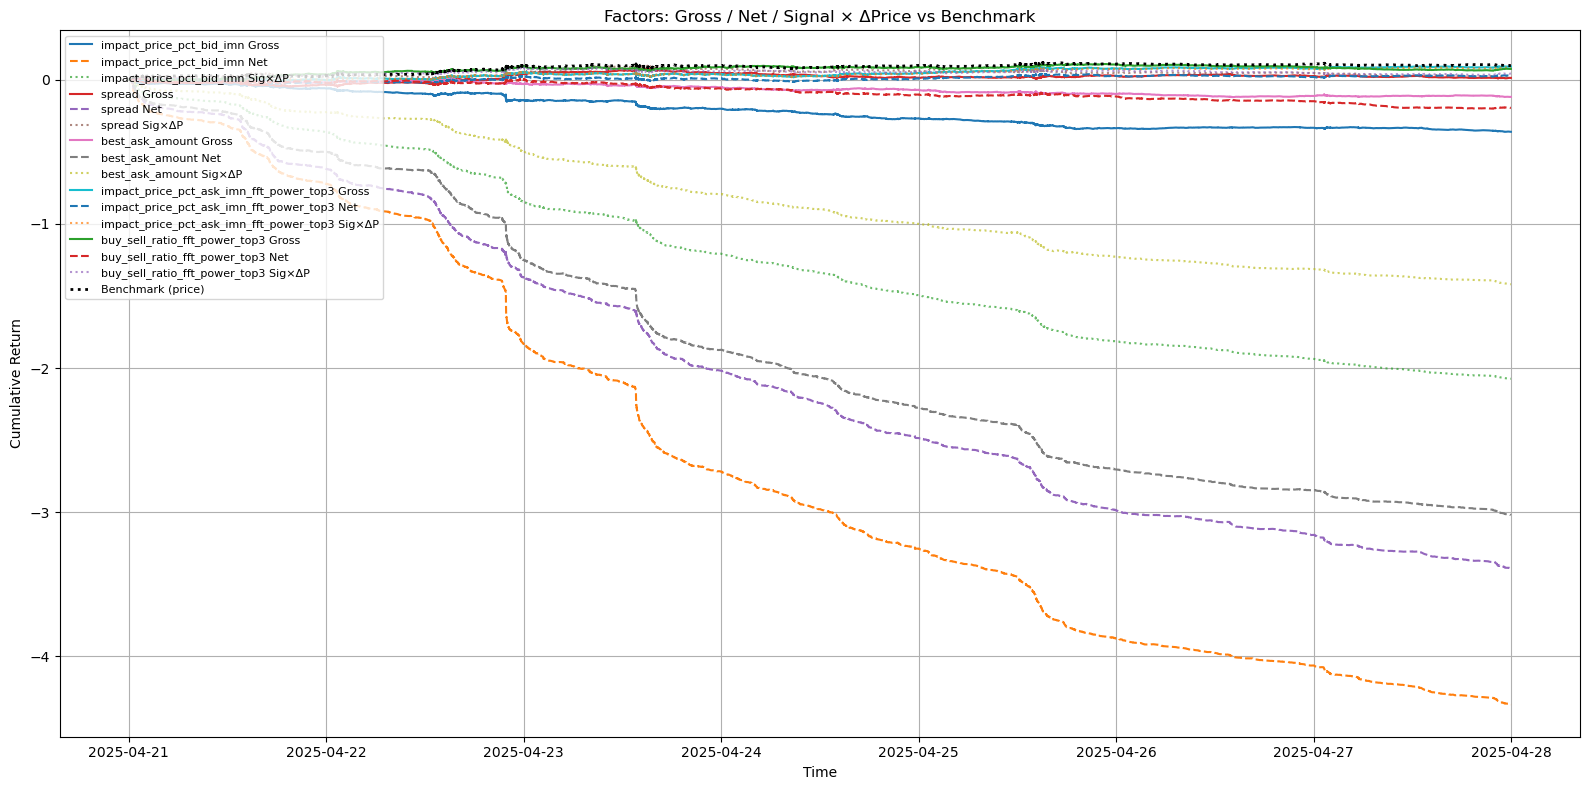

In [766]:
plt.figure(figsize=(16, 8))
step = 1

price = df_cum_sum["price"]
price_change = (price / price.shift(1) - 1).fill_null(0)

for f, is_rev in top20_info:
    suffix = "_rev" if is_rev else ""
    gross_col = f"cum_strategy_return_{f}{suffix}"
    net_col = f"cum_net_return_{f}{suffix}"
    signal_col = f"signal_{f}{suffix}"

    if any(col not in df_cum_sum.columns for col in [gross_col, net_col, signal_col]):
        print(f"‚ö†Ô∏è Missing column for factor {f} (rev={is_rev})")
        continue

    gross_arr = df_cum_sum[gross_col].to_numpy()
    net_arr = df_cum_sum[net_col].to_numpy()
    signal_arr = df_cum_sum[signal_col].fill_null(0).to_numpy()
    sig_price_return_arr = (signal_arr * price_change.to_numpy()).astype(float)
    cum_sig_price_return = np.cumsum(sig_price_return_arr)

    if PLOT_POSITIVE_ONLY:
        gross_arr = np.clip(gross_arr, a_min=0, a_max=None)
        net_arr = np.clip(net_arr, a_min=0, a_max=None)
        cum_sig_price_return = np.clip(cum_sig_price_return, a_min=0, a_max=None)

    print(f"\n==== Factor: {f}{suffix} ====")
    print("Net return head:", net_arr[:5])
    print("Net return tail:", net_arr[-5:])
    print("Final net return:", net_arr[-1])
    print("Signal √ó Price return tail:", cum_sig_price_return[-5:])
    print("Final signal √ó price return:", cum_sig_price_return[-1])

    time_sampled = time[::step]
    gross_arr_sampled = gross_arr[::step]
    net_arr_sampled = net_arr[::step]
    sig_price_sampled = cum_sig_price_return[::step]

    plt.plot(time_sampled, gross_arr_sampled, label=f"{f}{suffix} Gross", linestyle="-")
    plt.plot(time_sampled, net_arr_sampled, label=f"{f}{suffix} Net", linestyle="--")
    plt.plot(time_sampled, sig_price_sampled, label=f"{f}{suffix} Sig√óŒîP", linestyle=":", alpha=0.7)  # ‚≠ê Êñ∞Â¢ûÂõæ

# benchmark
price_return_arr = (df_cum_sum["price"] / df_cum_sum["price"].shift(1) - 1).fill_null(0).to_numpy()
cum_price_return = np.cumsum(price_return_arr)
cum_price_return_sampled = cum_price_return[::step]

plt.plot(time_sampled, cum_price_return_sampled, label="Benchmark (price)", color="black", linewidth=2, linestyle=":")

plt.title("Factors: Gross / Net / Signal √ó ŒîPrice vs Benchmark")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


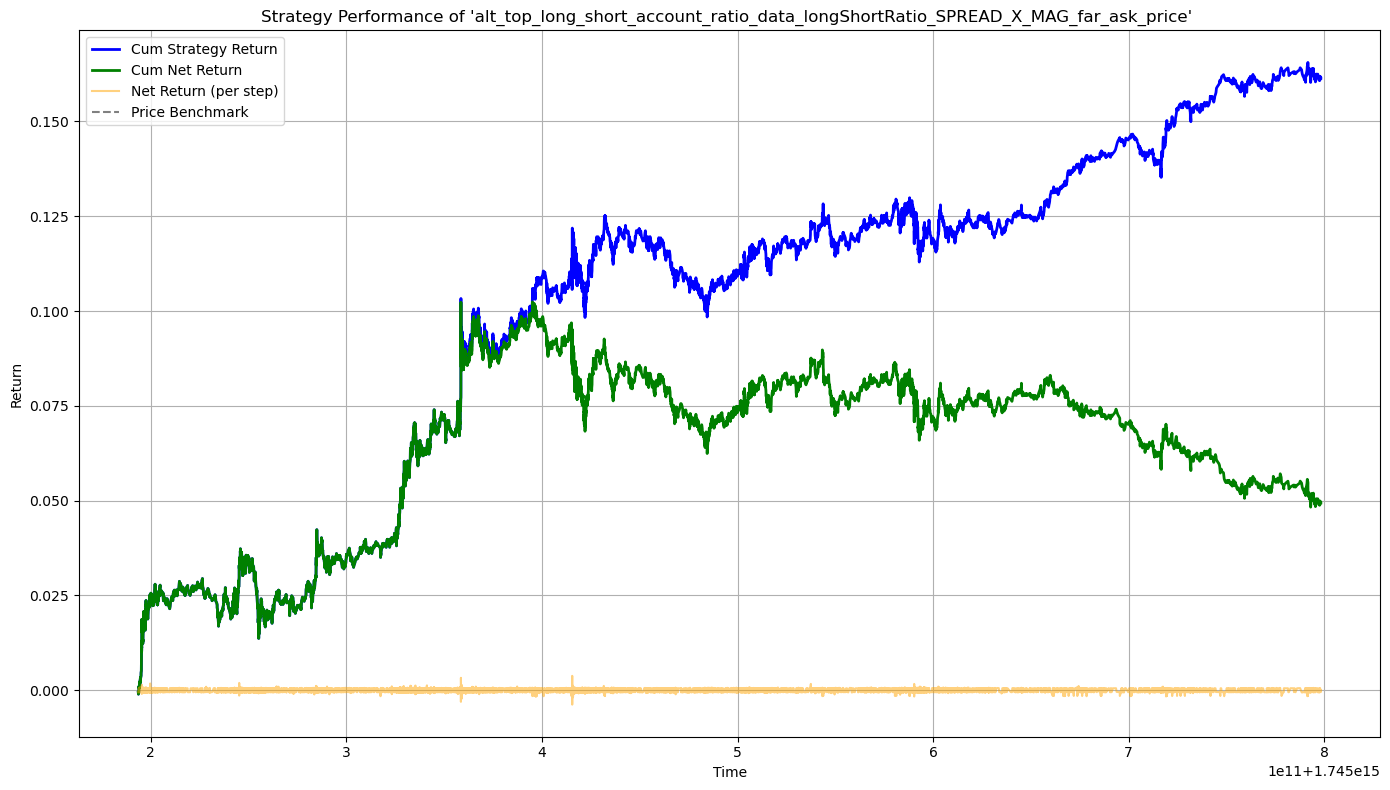

In [774]:
import matplotlib.pyplot as plt
import polars as pl

def plot_strategy_performance(df: pl.DataFrame, factor: str, reversed: bool = False):
    mode = "_rev" if reversed else ""
    signal_col = f"signal_{factor}{mode}"
    strat_col = f"strategy_return_{factor}{mode}"
    cum_strat_col = f"cum_strategy_return_{factor}{mode}"
    net_ret_col = f"net_return_{factor}{mode}"
    cum_net_col = f"cum_net_return_{factor}{mode}"
    time_col = df.columns[0]  # ÈªòËÆ§Á¨¨0ÂàóÊòØÊó∂Èó¥Êà≥
    price_col = "price"       # ÂÅáËÆæ benchmark ÊòØ‰ª∑Ê†º

    # ËΩ¨Êàê pandasÔºå‰æø‰∫éÁîªÂõæ
    pdf = df.select([
        time_col,
        price_col,
        strat_col,
        cum_strat_col,
        net_ret_col,
        cum_net_col
    ]).to_pandas()

    # ÂΩí‰∏ÄÂåñ benchmark price
    price_return_arr = (pdf["price"] / pdf["price"].shift(1) - 1).to_numpy()
    pdf["price_benchmark"] = np.cumsum(price_return_arr)

    plt.figure(figsize=(14, 8))

    plt.plot(pdf[time_col], pdf[cum_strat_col], label="Cum Strategy Return", color="blue", linewidth=2)
    plt.plot(pdf[time_col], pdf[cum_net_col], label="Cum Net Return", color="green", linewidth=2)
    plt.plot(pdf[time_col], pdf[net_ret_col], label="Net Return (per step)", color="orange", alpha=0.5)
    plt.plot(pdf[time_col], pdf["price_benchmark"], label="Price Benchmark", color="gray", linestyle="--")

    plt.title(f"Strategy Performance of '{factor}' {'(Reversed)' if reversed else ''}")
    plt.xlabel("Time")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_strategy_performance(df_cum_sum, factor="alt_top_long_short_account_ratio_data_longShortRatio_SPREAD_X_MAG_far_ask_price", reversed=False)

# Ëã•‰Ω†ÊÉ≥ÁîªÂèçÂêë‰ø°Âè∑ÁöÑÊïàÊûúÔºö


In [745]:
print(df["impact_sensitivity_diff_1"])

shape: (11_757,)
Series: 'impact_sensitivity_diff_1' [f64]
[
	null
	-0.00007
	0.000004
	0.000119
	0.000342
	‚Ä¶
	-0.000002
	0.000005
	-0.000005
	-3.5658e-7
	-0.000015
]


In [416]:
f = 'spread_skew'
print(df_cum_sum.select([
    f,
    f"signal_{f}",
    f"strategy_return_{f}",
    f"cum_strategy_return_{f}"
]).tail(10))


shape: (10, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ spread_skew ‚îÜ signal_spread_skew ‚îÜ strategy_return_spread_skew ‚îÜ cum_strategy_return_spread_ske‚Ä¶ ‚îÇ
‚îÇ ---         ‚îÜ ---                ‚îÜ ---                         ‚îÜ ---                             ‚îÇ
‚îÇ f64         ‚îÜ i32                ‚îÜ f64                         ‚îÜ f64                             ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 12.096145   ‚îÜ 1                  ‚îÜ -0.00

In [ ]:
names = [item[0] for item in top20]
names

In [ ]:
second_diff = np.diff(cum_returns, n=2)
smoothness = np.mean(np.abs(second_diff))
print(f"Smoothness (mean abs second diff): {smoothness:.6f}")


In [ ]:
import pandas as pd

returns = pd.Series(np.diff(cum_returns))
autocorr = returns.autocorr(lag=100)
print(f"Autocorrelation of returns (lag=1): {autocorr:.4f}")


In [298]:
import numpy as np

def sharpe_ratio_non_annualized(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    mean_excess_return = np.mean(excess_returns)
    std_excess_return = np.std(excess_returns, ddof=1)
    if std_excess_return == 0:
        return np.nan
    sharpe = mean_excess_return / std_excess_return
    return sharpe


sharpe = sharpe_ratio_non_annualized(cum_returns)

print(f"Non-annualized Sharpe Ratio: {sharpe:.4f}")


NameError: name 'cum_returns' is not defined

In [ ]:
df

In [ ]:
ic_rank = good_factors      # ÂÅáËÆæÔºöÊ†πÊçÆ IC ÂÄºÊéíÂêçÈù†ÂâçÁöÑÂõ†Â≠ê
sharpe_rank = [
 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_mid_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_LOGR_mid_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_far_ask_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_LOGR_far_ask_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_best_bid_price',]   # ÂÅáËÆæÔºöÂü∫‰∫éÂõ†Â≠êÁªÑÂêàÂ§èÊôÆÁéáÊéíÂ∫è
cumret_rank = [
 'alt_trade_taker_long_short_ratio_data_buySellRatio_LOGR_best_ask_price',
 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_far_bid_price']   # ÂÅáËÆæÔºöÂü∫‰∫éÂõ†Â≠êÁªÑÂêàÁ¥ØËÆ°Êî∂ÁõäÊéíÂ∫è
ir_rank =[]     # ÂÅáËÆæÔºöÊ†πÊçÆ IC ÂÄºÊéíÂêçÈù†ÂâçÁöÑÂõ†Â≠ê

bug_col = []
# bug_col = ['change_side', 'price_pct_change', 'trades_side', 'ret'
#            , 'orderflow',
#            'divergence', 'impact', 'sum', 'mid', 'price', 'buy_sell', 'factor_momentum_volume',
#             'oi_trend']
exclude_prefixes = ['timestamp', 'timestamp_dt', 'symbol', 'hour_group'] + bug_col

# Ëøõ‰∏ÄÊ≠•ÊéíÈô§Â≠óÊÆµÂêç‰∏≠ÂåÖÂê´ bug_col ‰ªª‰Ωï‰∏ÄÈ°π‰Ωú‰∏∫Â≠ê‰∏≤ÁöÑÂ≠óÊÆµ
factors = [
    col for col in df.columns
    if not any(col.startswith(prefix) for prefix in exclude_prefixes) 
    and not any(bug in col for bug in bug_col)
    and not col.startswith("future_return")
    and col != "price"
]
target_col_for_cal = f"future_return_{avg_steps_2pct}"


In [ ]:
# ÂàõÂª∫Áªü‰∏ÄÁöÑ‚Äú‰øùÁïôÂõ†Â≠ê‚ÄùÈõÜÂêàÔºà‰ªªÊÑè‰∏Ä‰∏™Ê¶úÂçïÂÖ•ÈÄâÂ∞±‰øùÁïôÔºâ
keep_set = set(ic_rank) | set(ir_rank) | set(sharpe_rank) | set(cumret_rank)
# Áî® list Êé®ÂØºÁîüÊàêÊñ∞Âõ†Â≠êÊ±†
filtered_factors = [f for f in factors if f in keep_set]

# ÂèØÈÄâÔºöÊâìÂç∞‰øùÁïô‰∫ÜÂ§öÂ∞ë
print(f"‰øùÁïôÂõ†Â≠êÊï∞Ôºö{len(filtered_factors)} / ÂéüÂßãÂõ†Â≠êÊï∞Ôºö{len(factors)}")

# ÂèØÈÄâÔºöÊèêÂèñÂá∫Êñ∞ÁöÑ Polars Â≠ê DataFrame
filtered_df = df.select(filtered_factors + [target_col_for_cal])  # Âä†‰∏äÁõÆÊ†áÂàóÊñπ‰æøÂêéÁª≠Âª∫Ê®°


In [ ]:
rank_weights = {
    "ic": 1.2,
    "ir": 1.0,
    "sharpe": 1.2,
    "cumret": 1.5,
}

# ÊØè‰∏™Âõ†Â≠êÊâìÂàÜ
from collections import defaultdict

score = defaultdict(float)
for f in ic_rank:
    score[f] += rank_weights["ic"]
for f in ir_rank:
    score[f] += rank_weights["ir"]
for f in sharpe_rank:
    score[f] += rank_weights["sharpe"]
for f in cumret_rank:
    score[f] += rank_weights["cumret"]

# Âè™‰øùÁïôÂàÜÊï∞Â§ß‰∫é‰∏ÄÂÆöÈòàÂÄºÁöÑÂõ†Â≠ê
filtered_factors = [f for f in factors if score[f] >= 1.0]
print(filtered_factors)

In [ ]:
def pl_dropna(df: pl.DataFrame) -> pl.DataFrame:

    pdf = df.to_pandas()
    pdf_clean = pdf.dropna()
    return pl.from_pandas(pdf_clean)

In [ ]:
def filter_by_spearman_corr(df: pl.DataFrame, factor_cols: list[str], threshold: float = 0.9) -> list[str]:
    matrix = np.column_stack([df[col].to_numpy() for col in factor_cols])
    
    corr_matrix, _ = spearmanr(matrix)  # ‰∏ÄÊ¨°ÊÄßËÆ°ÁÆóÊâÄÊúâÂõ†Â≠êÁöÑ Spearman Áõ∏ÂÖ≥Á≥ªÊï∞Áü©ÈòµÔºåshape = (n, n)
    n = len(factor_cols)
    keep = []
    removed = set()
    
    print("Spearman correlation matrix:")
    print(np.round(corr_matrix, 3))
    
    for i in range(n):
        if factor_cols[i] in removed:
            # print(f"Skip {factor_cols[i]} as it is removed")
            continue
        keep.append(factor_cols[i])
        # print(f"Keep {factor_cols[i]}")
        
        for j in range(i+1, n):
            if factor_cols[j] in removed:
                continue

            corr_value = corr_matrix[i, j]

            if abs(corr_value) >= threshold:
                removed.add(factor_cols[j])
                # print(f"Remove {factor_cols[j]} because corr({factor_cols[i]}, {factor_cols[j]}) = {corr_value:.3f} >= {threshold}")

    return keep


In [ ]:
from sklearn.feature_selection import mutual_info_regression

def filter_by_mutual_info(df: pl.DataFrame, factor_cols: list[str], target_col: str, top_k: int = 50) -> list[str]:
    """
    Ê†πÊçÆ‰∫í‰ø°ÊÅØ‰øùÁïôÂâç top_k ‰∏™ÂíåÁõÆÊ†áÂèòÈáèÁõ∏ÂÖ≥ÊÄßÊúÄÂº∫ÁöÑÂõ†Â≠ê„ÄÇ

    Args:
        df: Polars DataFrame
        factor_cols: ÂéüÂßãÂõ†Â≠êÂàó
        target_col: ÁõÆÊ†áÊî∂ÁõäÂàó
        top_k: ‰øùÁïôÂâç k ‰∏™Âõ†Â≠ê

    Returns:
        ‰øùÁïôÁöÑÂõ†Â≠êÂàóÂêçÂàóË°®
    """
    X = np.column_stack([df[col].to_numpy() for col in factor_cols])
    y = df[target_col].to_numpy()

    mi_scores = mutual_info_regression(X, y, discrete_features=False)
    sorted_idx = np.argsort(mi_scores)[::-1]
    selected = [factor_cols[i] for i in sorted_idx[:top_k]]

    return selected


In [ ]:
f_df = df.select(filtered_factors + [target_col_for_cal]).drop_nulls()
f_df

In [ ]:
# Á¨¨‰∏ÄÊ≠•ÔºöÂÖàÁî® spearman ËøáÊª§ÂÜó‰Ωô
low_corr_factors = filter_by_spearman_corr(f_df, factor_cols=filtered_factors, threshold=0.95)

# Á¨¨‰∫åÊ≠•ÔºöÂÜçÁî® MI ÈÄâÂá∫Ââç k ‰∏™‰ø°ÊÅØÈáèÊúÄÂ§ßÁöÑÂõ†Â≠ê
final_selected_factors = filter_by_mutual_info(f_df, low_corr_factors, target_col=target_col_for_cal, top_k=30)


In [ ]:
print(low_corr_factors)
print(final_selected_factors)
# ['alt_factor_long_term_oi_trend_momentum_ratio_1', 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_mid_price', 'alt_factor_short_term_oi_trend_DIV_impact_price_pct_ask_imn', 'alt_factor_short_term_oi_trend_DIV_spread', 'alt_factor_long_term_oi_trend_DIV_impact_price_pct_bid_imn', 'alt_factor_long_term_oi_trend_DIV_mid_price', 'price_pct_change_alt_factor_long_term_oi_trend_impact_price_pct_ask_imn_max_mean_min_ratio', 'price_pct_change_alt_factor_long_term_oi_trend_ret_1_max_mean_min_ratio', 'alt_factor_short_term_oi_trend_impact_price_pct_ask_imn_impact_price_pct_bid_imn_max_mean_min_ratio', 'alt_factor_long_term_oi_trend_impact_price_pct_bid_imn_ret_1_lag_max_mean_min_ratio']
# ['alt_factor_long_term_oi_trend_DIV_impact_price_pct_bid_imn', 'alt_factor_short_term_oi_trend_DIV_spread', 'alt_factor_short_term_oi_trend_DIV_impact_price_pct_ask_imn', 'alt_trade_taker_long_short_ratio_data_buySellRatio_DIV_mid_price', 'alt_factor_long_term_oi_trend_DIV_mid_price', 'price_pct_change_alt_factor_long_term_oi_trend_impact_price_pct_ask_imn_max_mean_min_ratio', 'alt_factor_long_term_oi_trend_impact_price_pct_bid_imn_ret_1_lag_max_mean_min_ratio', 'alt_factor_long_term_oi_trend_momentum_ratio_1', 'alt_factor_short_term_oi_trend_impact_price_pct_ask_imn_impact_price_pct_bid_imn_max_mean_min_ratio', 'price_pct_change_alt_factor_long_term_oi_trend_ret_1_max_mean_min_ratio']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

def plot_spearman_corr_heatmap(df: pl.DataFrame, factor_cols: list[str], max_len: int = 20):
    matrix = np.column_stack([df[col].to_numpy() for col in factor_cols])
    corr_matrix, _ = spearmanr(matrix)

    # Êà™Êñ≠ÈïøÂêçÁß∞
    short_names = [name if len(name) <= max_len else name[:max_len-3] + "..." for name in factor_cols]

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix,
                xticklabels=short_names,
                yticklabels=short_names,
                cmap='cool',
                center=0,
                annot=False,
                square=True,
                cbar_kws={"shrink": .8})

    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.title("Spearman Correlation Heatmap (Short Names)")
    plt.tight_layout()
    plt.show()
    print("corr_matrix max:", np.max(corr_matrix))
    print("corr_matrix min:", np.min(corr_matrix))
    print("corr_matrix mean:", np.mean(corr_matrix))

plot_spearman_corr_heatmap(f_df, final_selected_factors)

In [ ]:
df = df.drop_nulls()
df